# Proyecto Final

### Jorge Villarrubia Elvira y Juan Carlos Villanueva Quirós

In [ ]:
#Todas las librerias externas usadas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as opt

from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

Primero, cargamos el dataset.

In [3]:
#Leemos el data set
loan_rawdf = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
#Vemos los primeros para comprobar si se han cargado correctamente
loan_rawdf.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


Ahora, procedemos a realizar el preprocesado de datos. Para ello, vamos a:
- Comprobar si hay valores nulos y arreglarlos si es necesario.
- Deshacernos de variables poco útiles (las que esten muy correlacionadas entre sí).
- Comprobar que los valores de las categorías sean plausibles y modificarlos si es necesario.
- Discretizar un poco más en rangos algunas variables continuas no eliminadas como los ingresos (no tiene sentido otras como el nivel educativo que apenas toma 4 valores distintos).
- Hacer la partición de los datos en conjunto de entrenamiento, validación y test.
- Normalizar los datos (aunque algunos de nuestros modelos no lo necesiten tenemos rangos muy distintos como los ingresos y el nivel educativo y los modelos suelen funcionar mejor reescalando).

Afortunadamente no tenemos valores nulos.

In [4]:
#Comprobamos si tenemos valores nulos
loan_rawdf.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

Ahora, visualicemos el data set y veamos las principales características. Llama la atención es desbalanceo de la clase Personal Loan a predecir que tendremos que tener en cuenta en adelante y el histograma de ZIP Code.

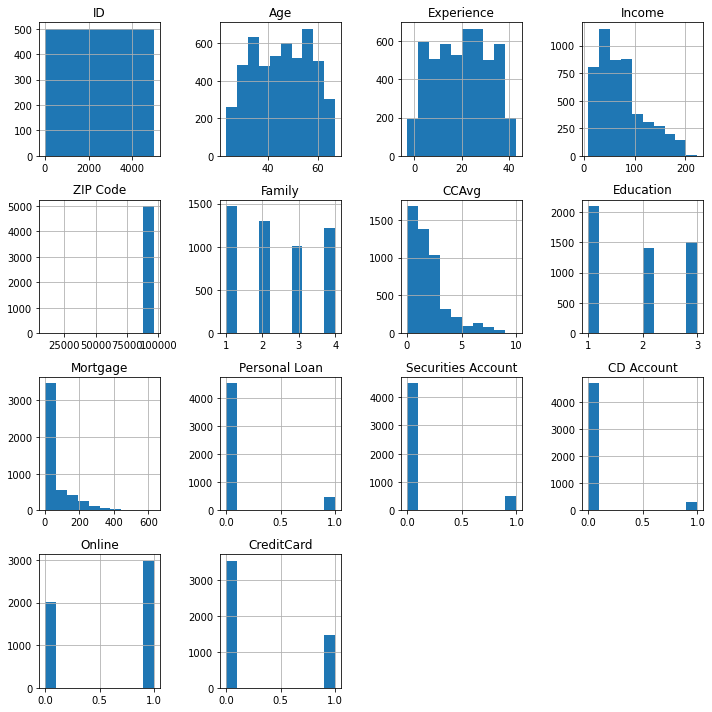

In [5]:
#Visualizamos los datos
loan_rawdf.hist(figsize=(10,10))
plt.tight_layout()

Hay un ejemplo cuyo ZIP code está equivocado. Lo eliminamos.

In [6]:
np.sum(loan_rawdf['ZIP Code']< 90000)
loan_rawdf[loan_rawdf['ZIP Code']< 90000]['ZIP Code']

384    9307
Name: ZIP Code, dtype: int64

In [7]:
loan_rawdf = loan_rawdf.drop(index=loan_rawdf[loan_rawdf['ZIP Code']< 90000]['ZIP Code'].index)

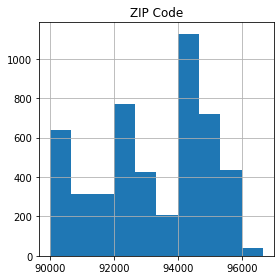

In [8]:
loan_rawdf['ZIP Code'].hist(figsize=(4,4))
plt.title('ZIP Code')
plt.tight_layout()

Nos fijamos en la correlación entre las variables. Observamos un un 0.99 de correlación entre Experience y Age que hace que podamos eliminar una de las dos. Eliminamos Experience. Eliminamos también ID que simplemente indica el número de fila e cada ejemplo y no tiene ningún sentido.

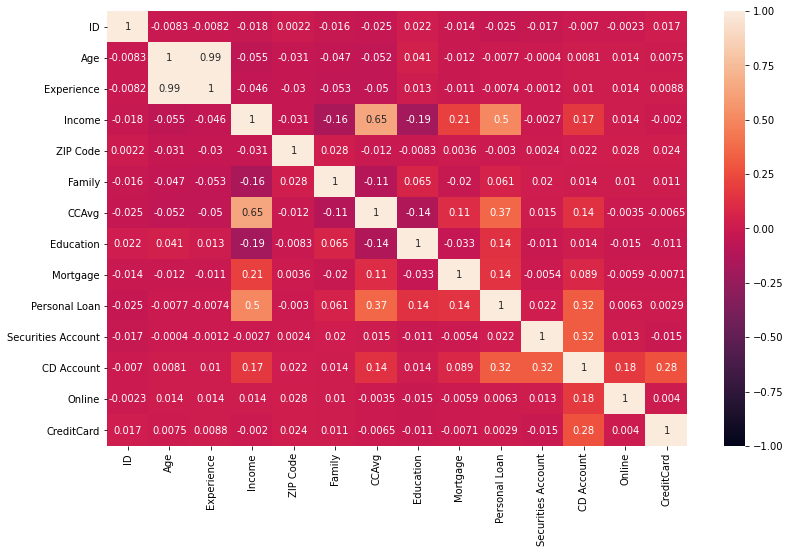

In [9]:
plt.figure(figsize=(13, 8))
sns.heatmap(loan_rawdf.corr(), annot=True, vmin=-1, vmax=1)

In [10]:
loan_rawdf = loan_rawdf.drop(columns=['Experience'])
loan_rawdf = loan_rawdf.drop(columns=['ID'])

En la visualización de los datos podemos observar que algunos valores de la columna _experiencia_ son negativos. Esto no tiene mucho sentido pues dicha categoría representa los años de experiencia profesional. Como decidimos eliminarlas no hay falta preocuparse de ello.

In [11]:
#Imprimimos la informacion del data set
loan_rawdf.info()

#Imprimimos tambien las estadisticas principales
loan_rawdf.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 4999 non-null   int64  
 1   Income              4999 non-null   int64  
 2   ZIP Code            4999 non-null   int64  
 3   Family              4999 non-null   int64  
 4   CCAvg               4999 non-null   float64
 5   Education           4999 non-null   int64  
 6   Mortgage            4999 non-null   int64  
 7   Personal Loan       4999 non-null   int64  
 8   Securities Account  4999 non-null   int64  
 9   CD Account          4999 non-null   int64  
 10  Online              4999 non-null   int64  
 11  CreditCard          4999 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 507.7 KB


,Age,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000
mean,45.337267,73.784757,93169.275455,2.396079,1.938206,1.880776,56.510102,0.096019,0.104421,0.060412,0.596719,0.293859
std,11.464033,46.032281,1759.630610,1.147554,1.747731,0.839804,101.720837,0.294647,0.305836,0.238273,0.490605,0.455574
min,23.000000,8.000000,90005.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,55.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,67.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
print("Primer tercil de 'Age': ", np.percentile(loan_rawdf.Age, 33.33))
print("Segundo tercil de 'Age': ", np.percentile(loan_rawdf.Age, 66.66))

Primer tercil de 'Age':  39.0
Segundo tercil de 'Age':  52.0


Discretizamos la variable Age donde quizás podría interesarnos una información más general (jóven, mediana edad y mayor) en lugar de los años concretos. La persona más jóven tiene 8 años y la más mayor 67

In [13]:
age_values = loan_rawdf.Age
bins = [np.min(age_values) ,39, 52, np.max(age_values)]
loan_rawdf['Age'] = pd.cut(age_values, bins, labels=bins[:-1], include_lowest = True)
loan_rawdf

,Age,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,23,49,91107,4,1.6,1,0,0,1,0,0,0
1,39,34,90089,3,1.5,1,0,0,1,0,0,0
2,23,11,94720,1,1.0,1,0,0,0,0,0,0
3,23,100,94112,1,2.7,2,0,0,0,0,0,0
4,23,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,23,40,92697,1,1.9,3,0,0,0,0,1,0
4996,23,15,92037,4,0.4,1,85,0,0,0,1,0
4997,52,24,93023,2,0.3,3,0,0,0,0,0,0
4998,52,49,90034,3,0.5,2,0,0,0,0,1,0


Visualizamos a cantidad de casos de cada clase

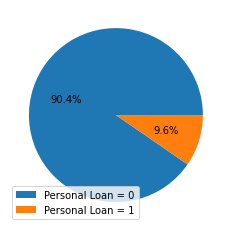

In [14]:
plt.pie(data=loan_rawdf,x=loan_rawdf["Personal Loan"].value_counts(),autopct='%1.1f%%')
plt.legend(['Personal Loan = 0','Personal Loan = 1'], loc="lower left")

### Separación de los datos en entrenamiento, validación y test.
Hacemos un partición 60% para test, 20% para validación y 20% para test. Primero partimos 80%-20%, y luego el de 80% lo partimos 75%-25% (el 75% del 80% es el 60% del original y el 25% del 80% es el 20%). Para no desbalancear aún más el dataset en nuetros conjuntos hacemos estas particiones estratificadas. Comprobamos que el porcentaje de casos de cada clase es el mismo en los 3 conjuntos e igual al del dataset.

In [15]:
X = loan_rawdf.loc[:, loan_rawdf.columns != 'Personal Loan'].to_numpy()
y = loan_rawdf['Personal Loan'].to_numpy()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=333, stratify = y_train)

In [17]:
print('Porcentaje de la clase 0 en entrenamiento: ', np.sum(y_train == 0) / len(y_train)*100, '%') 
print('Porcentaje de la clase 1 en entrenamiento: ', np.sum(y_train == 1) / len(y_train)*100, '%') 
print('Porcentaje de la clase 0 en validación: ', np.sum(y_val == 0) / len(y_val)*100, '%') 
print('Porcentaje de la clase 1 en validación: ', np.sum(y_val == 1) / len(y_val)*100, '%') 
print('Porcentaje de la clase 0 en test: ', np.sum(y_test == 0) / len(y_test)*100, '%') 
print('Porcentaje de la clase 1 en test: ', np.sum(y_test == 1) / len(y_test)*100, '%') 

Porcentaje de la clase 0 en entrenamiento:  90.39679893297766 %
Porcentaje de la clase 1 en entrenamiento:  9.60320106702234 %
Porcentaje de la clase 0 en validación:  90.4 %
Porcentaje de la clase 1 en validación:  9.6 %
Porcentaje de la clase 0 en test:  90.4 %
Porcentaje de la clase 1 en test:  9.6 %


### Normalización de los datos
Para el mejor funcionamiento de algunos modelos normalizamos los datos para que tengan una escala similar y pequeña. Es importante normalizar por separado los conjuntos de train, eval y test para no contaminar los conjunto de prueba con información de entrenamiento.

In [18]:
def normalize_data(X):
    """
    Args:
        X: Datos de entrada
        
    Dados unos datos de entrada, los normaliza haciendo (datos - media) / desviacion_estandar.
    Ademas, devuelve las medias y desviaciones estandar obtenidas
    """  
    media = np.mean(X, axis = 0)
    desviacion = np.std(X, axis = 0)
    print(media)
    print(desviacion)
    return (X - media) / desviacion, media, desviacion 

In [19]:
X_train_norm, _, _ = normalize_data(X_train)
X_val_norm, _ ,_ = normalize_data(X_val)
X_test_norm, _ ,_ = normalize_data(X_test)

[3.76595532e+01 7.37515839e+01 9.31395158e+04 2.37912638e+00
 1.93172724e+00 1.87762588e+00 5.54661554e+01 1.03701234e-01
 5.66855619e-02 5.94198066e-01 2.94431477e-01]
[1.18248782e+01 4.61403036e+01 1.78526735e+03 1.14502466e+00
 1.74485967e+00 8.36418614e-01 1.00130146e+02 3.04872576e-01
 2.31240803e-01 4.91046560e-01 4.55786773e-01]
[3.7183000e+01 7.2417000e+01 9.3185745e+04 2.4590000e+00 1.9110200e+00
 1.8950000e+00 5.8364000e+01 1.1300000e-01 6.2000000e-02 6.1600000e-01
 2.8800000e-01]
[1.18957770e+01 4.54807114e+01 1.71901001e+03 1.15426124e+00
 1.73013224e+00 8.41412503e-01 1.05281288e+02 3.16592798e-01
 2.41155551e-01 4.86357893e-01 4.52831094e-01]
[3.7825000e+01 7.5252000e+01 9.3242055e+04 2.3840000e+00 1.9848200e+00
 1.8760000e+00 5.7787000e+01 9.8000000e-02 7.0000000e-02 5.8500000e-01
 2.9800000e-01]
[1.19566038e+01 4.61891816e+01 1.71864362e+03 1.14566313e+00
 1.77193628e+00 8.47716934e-01 1.02734374e+02 2.97314648e-01
 2.55147016e-01 4.92722031e-01 4.57379492e-01]


## Regresión Logística

In [20]:
#Funciones relacionadas con las metricas

def metricas(predicted, correct):
    accuracy = np.sum(predicted == correct) / len(correct)
    if np.sum(predicted == 1) == 0:
        precision = 0
    else:
        precision = np.sum(np.logical_and(predicted == 1, predicted == correct))/np.sum(predicted == 1)
    if np.sum(correct == 1) == 0:
        recall = 0
    else:
        recall = np.sum(np.logical_and(predicted == 1, predicted == correct))/np.sum(correct == 1)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2*precision*recall/(precision + recall)
    return accuracy, precision, recall, f1

def muestraMetricas(predicted, correct):
    accuracy, precision, recall, f1 = metricas(predicted, correct)
    print('Accuracy obtenido: {}'.format(accuracy))
    print('Precisión obtenida: {}'.format(precision))
    print('Recall obtenido: {}'.format(recall))
    print('F1 obtenido: {}'.format(f1))
    
#Funcion que dibuja la matriz de confusion.
#Extraida de  https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred,normalize=False,title=None,cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [21]:
# Funcion sigmoide, coste y gradiente que usaremos para el entrenamiento de los clasificadores de regresion logistica
def sigmoide(z):
    return 1 / (1 + np.exp(-z))

def costeRegu(theta, X, Y, lamda):
    m = np.shape(X)[0]
    return (np.matmul(np.log(sigmoide(np.matmul(X, theta))).T, Y)\
    + np.matmul(np.log(1 - sigmoide(np.matmul(X, theta)) + 1e-6).T, (1-Y)))/-m\
    + lamda* np.sum(theta**2)/(2*m)

def gradienteRegu(theta, X, Y, lamda):
    m = np.shape(X)[0]
    aux = lamda/m * theta
    aux[0] = 0
    return np.matmul(X.T, sigmoide(np.matmul(X,theta)) - Y)/m + aux

In [22]:
#Anadimos columna de unos a los datos de entrenamiento, evaluacion y test
X_train_norm_unos = np.hstack([np.ones([X_train_norm.shape[0], 1]), X_train_norm])
X_val_norm_unos = np.hstack([np.ones([X_val_norm.shape[0], 1]), X_val_norm])
X_test_norm_unos = np.hstack([np.ones([X_test_norm.shape[0], 1]), X_test_norm])

Función de test para elección de parametros que utilizaremos varias veces.

In [37]:
def testParam(X_train, y_train, X_val, y_val, rango_parametro, nombre_modelo, nombre_parametro = 'Parametro', random_state = 0, gamma = None, n_estimators =100) :
    precision_train_list = []
    precision_val_list = []
    recall_train_list = []
    recall_val_list = []
    f1_train_list = []
    f1_val_list = []
    for parametro in rango_parametro :
        #Entrenamos el modelo con los datos de entrenamiento
        if nombre_modelo == 'regresion logistica' :
            modelo = opt.fmin_tnc(func = costeRegu, x0 = np.zeros(X_train.shape[1]), fprime = gradienteRegu, args=(X_train, y_train, parametro))
            #En modelo[0] estan guardados los thetas (pesos) optimos
            predicted_train = sigmoide(np.matmul(X_train, modelo[0])) >= 0.5
            predicted_val = sigmoide(np.matmul(X_val, modelo[0])) >= 0.5
        elif nombre_modelo == 'arbol decision' :  
            modelo = DecisionTreeClassifier(criterion = 'entropy', max_depth = parametro, min_samples_split = 2, random_state = random_state)
            modelo = modelo.fit(X_train, y_train)
            predicted_train = modelo.predict(X_train)
            predicted_val = modelo.predict(X_val)
        elif nombre_modelo == 'random forest' :
            modelo = RandomForestClassifier(n_estimators =n_estimators, max_depth=parametro, random_state=random_state)
            modelo.fit(X_train, y_train)
            predicted_train = modelo.predict(X_train)
            predicted_val = modelo.predict(X_val)
        elif nombre_modelo == 'SVM linear':
            modelo = SVC(kernel = 'linear', C = parametro, random_state = random_state)
            modelo.fit(X_train, y_train)
            predicted_train = modelo.predict(X_train)
            predicted_val = modelo.predict(X_val)
        elif nombre_modelo == 'SVM gaussian':
            modelo = svm = SVC(kernel = 'rbf', C = parametro, gamma = gamma, random_state = random_state)
            modelo.fit(X_train, y_train)
            predicted_train = modelo.predict(X_train)
            predicted_val = modelo.predict(X_val)
        else :
            return 'Nombre de modelo no encontrado'
        
        #Metricas con datos de entrenamiento
        _, precision_train, recall_train, f1_train = metricas(predicted_train, y_train)
        precision_train_list.append(precision_train)
        recall_train_list.append(recall_train)
        f1_train_list.append(f1_train)
    
        #Metricas con datos evaluacion
        _, precision_val, recall_val, f1_val = metricas(predicted_val, y_val)
        precision_val_list.append(precision_val)
        recall_val_list.append(recall_val)
        f1_val_list.append(f1_val)

    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(12,4)
    ax1.plot(rango_parametro, precision_train_list, label = 'Train', color = 'blue')
    ax1.plot(rango_parametro, precision_val_list, label = 'Validation', color = 'red')
    ax1.set_xlabel(nombre_parametro)
    ax1.set_ylabel('Precision')
    ax1.set_title(nombre_parametro + ' vs Precision')
    ax1.legend()

    ax2.plot(rango_parametro, recall_train_list, label = 'Train', color = 'g')
    ax2.plot(rango_parametro, recall_val_list, label = 'Validation', color = 'black')
    ax2.set_xlabel(nombre_parametro)
    ax2.set_ylabel('Recall')
    ax2.set_title(nombre_parametro + ' vs Recall')
    ax2.legend()
    fig.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(rango_parametro, f1_train_list, label = 'Train', color = 'g')
    ax.plot(rango_parametro, f1_val_list, label = 'Validation', color = 'black')
    plt.xlabel(nombre_parametro)
    plt.ylabel('F1')
    ax.set_title(nombre_parametro + ' vs F1')
    plt.legend()
    plt.show()
    
    indice_maximo = f1_val_list.index(max(f1_val_list))
    print('Para el valor de ' + nombre_parametro + ' {} alcanzamos el f1 maximo en evaluacion: {}'.format(rango_parametro[indice_maximo], max(f1_val_list)))

Entrenamos modelos para varios valores de lambda (Explicar más a fondo aquí)

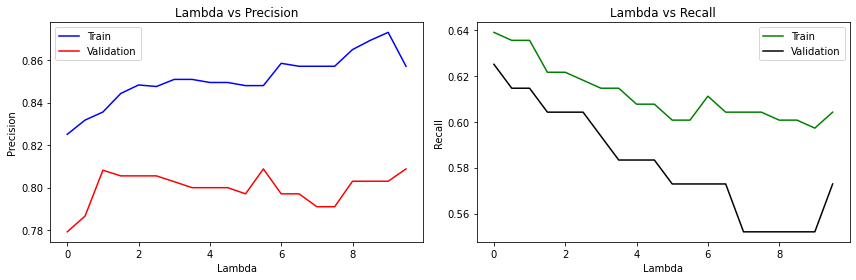

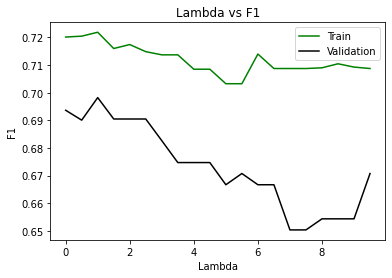

Para el valor de Lambda 1.0 alcanzamos el f1 maximo en evaluacion: 0.6982248520710059


In [ ]:
testParam(X_train_norm_unos, y_train, X_val_norm_unos, y_val, rango_parametro = np.arange(0, 10, 0.5),
          nombre_modelo = 'regresion logistica', nombre_parametro = 'Lambda')

Escogemos el valor de lambda para el que se maximiza F1 en evaluación: 1.0

Resultados para train
Accuracy obtenido: 0.9529843281093698
Precisión obtenida: 0.8356164383561644
Recall obtenido: 0.6354166666666666
F1 obtenido: 0.7218934911242603

Resultados para eval
Accuracy obtenido: 0.949
Precisión obtenida: 0.8082191780821918
Recall obtenido: 0.6145833333333334
F1 obtenido: 0.6982248520710059

Resultados para test
Accuracy obtenido: 0.953
Precisión obtenida: 0.855072463768116
Recall obtenido: 0.6145833333333334
F1 obtenido: 0.7151515151515152

Matriz de confusion
Confusion matrix, without normalization
[[894  10]
 [ 37  59]]


<AxesSubplot:title={'center':'Regresion logistica con lambda = 1.0'}, xlabel='Predicted label', ylabel='True label'>

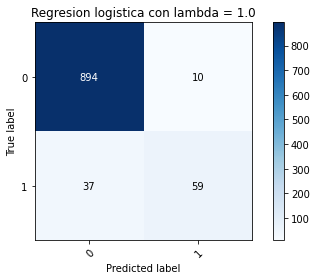

In [ ]:
lamda = 1.0
theta = np.zeros(X_train_norm_unos.shape[1])
result = opt.fmin_tnc(func = costeRegu, x0 = theta, fprime = gradienteRegu, args=(X_train_norm_unos, y_train, lamda))
theta_opt = result[0]

#Metricas con datos entrenamiento
predicted_train = sigmoide(np.matmul(X_train_norm_unos, theta_opt)) >= 0.5
print('Resultados para train')
muestraMetricas(predicted_train, y_train)

predicted_val = sigmoide(np.matmul(X_val_norm_unos, theta_opt)) >= 0.5
print('\nResultados para eval')
muestraMetricas(predicted_val, y_val)

predicted_test = sigmoide(np.matmul(X_test_norm_unos, theta_opt)) >= 0.5
print('\nResultados para test')
muestraMetricas(predicted_test, y_test)

print('\nMatriz de confusion')
plot_confusion_matrix(y_true = y_test, y_pred = predicted_test, normalize=False, title='Regresion logistica con lambda = {}'.format(lamda), cmap=plt.cm.Blues)

Ahora probamos con polinomios

In [ ]:
poly = PolynomialFeatures(3)
X_train_norm_poly = poly.fit_transform(X_train_norm)
X_val_norm_poly = poly.fit_transform(X_val_norm)
X_test_norm_poly = poly.fit_transform(X_test_norm)

d:\programas\anaconda3\envs\informaticatfg\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
d:\programas\anaconda3\envs\informaticatfg\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
d:\programas\anaconda3\envs\informaticatfg\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in matmul
  import sys


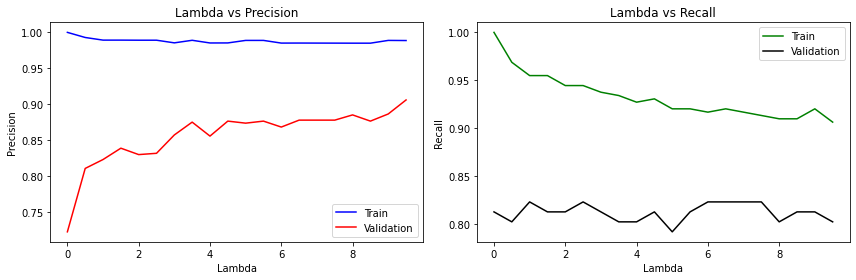

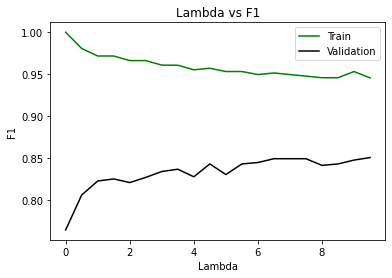

Para el valor de Lambda 9.5 alcanzamos el f1 maximo en evaluacion: 0.850828729281768


In [ ]:
testParam(X_train_norm_poly, y_train, X_val_norm_poly, y_val, rango_parametro = np.arange(0, 10, 0.5),
          nombre_modelo = 'regresion logistica', nombre_parametro = 'Lambda')

Escogemos lambda = 9.5

Resultados para train
Accuracy obtenido: 0.9899966655551851
Precisión obtenida: 0.9886363636363636
Recall obtenido: 0.90625
F1 obtenido: 0.9456521739130435

Resultados para eval
Accuracy obtenido: 0.973
Precisión obtenida: 0.9058823529411765
Recall obtenido: 0.8020833333333334
F1 obtenido: 0.850828729281768

Resultados para test
Accuracy obtenido: 0.979
Precisión obtenida: 0.9629629629629629
Recall obtenido: 0.8125
F1 obtenido: 0.8813559322033898

Matriz de confusion
Confusion matrix, without normalization
[[901   3]
 [ 18  78]]


<AxesSubplot:title={'center':'Regresion logistica con terminos polinomicos y lambda = 9.5'}, xlabel='Predicted label', ylabel='True label'>

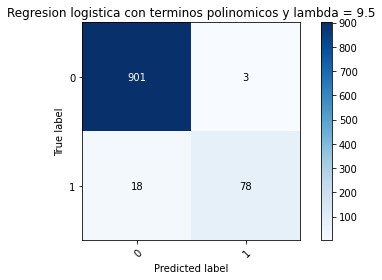

In [ ]:
lamda = 9.5
theta = np.zeros(X_train_norm_poly.shape[1])
result = opt.fmin_tnc(func = costeRegu, x0 = theta, fprime = gradienteRegu, args=(X_train_norm_poly, y_train, lamda))
theta_opt = result[0]

#Metricas con datos entrenamiento
predicted_train = sigmoide(np.matmul(X_train_norm_poly, theta_opt)) >= 0.5
print('Resultados para train')
muestraMetricas(predicted_train, y_train)

predicted_val = sigmoide(np.matmul(X_val_norm_poly, theta_opt)) >= 0.5
print('\nResultados para eval')
muestraMetricas(predicted_val, y_val)

predicted_test = sigmoide(np.matmul(X_test_norm_poly, theta_opt)) >= 0.5
print('\nResultados para test')
muestraMetricas(predicted_test, y_test)

print('\nMatriz de confusion')
plot_confusion_matrix(y_true = y_test, y_pred = predicted_test, normalize=False, title='Regresion logistica con terminos polinomicos y lambda = {}'.format(lamda), cmap=plt.cm.Blues)

## Redes neuronales

Funciones para el entrenamiento de redes neuronales

In [58]:
def forwardPropagation(X, layers):
    #La variable 'a' corresponde a la entrada de cada capa, que al principio seran los datos de entrada X.
    #Ojo: trasponemos para tratar las dimensiones correctamente
    m = X.shape[0]
    a = X
    A = []
    #Propagación hacia delante genérica que sirve para más de 2 matrices
    for i in range(len(layers)):
        #Añadimos unos a la entrada de cada capa (los terminos independientes)
        a = np.hstack([np.ones([m, 1]), a])
        A.append(a)
        
        #Cogemos los pesos correspondientes a la capa que toca
        thetas = layers[i]
        #Hacemos la multiplicacion
        z = np.matmul(a, thetas.T)
        
        #Y por ultimo la funcion de activacion
        a = sigmoide(z)
        
    A.append(a)
    #Al salir del bucle, tendremos la salida de la red neuronal
    #Trasponemos para devolver la misma forma que los datos de entrada
    return A, a

def sigmoide(z):
    return 1 / (1 + np.exp(-z))

def costeNeuronalRegu(X,Y, layers, regu):
    _, h = forwardPropagation(X, layers)
    m = X.shape[0]
    reguTerm = 0
    # Para tantas matrices como nos pasen.
    # Así es genérico, en lugar de hacerlo para 2 matrices como en los apuntes
    for layer in layers:
        #Quitamos la última columna de 1's
        reguTerm += np.sum(layer[:,1:]**2)
    reguTerm *= regu/(2*m)
    return np.sum(Y * np.log(h+1e-8) + (1 - Y) * np.log(1-h +1e-8))*-1/m + reguTerm

def backprop(params_rn, num_entradas, ocultas_dims, num_etiquetas, X, y, reg):
    m = X.shape[0]
    dims = (num_entradas,) + ocultas_dims + (num_etiquetas,)
    L = len(dims)
    layers = []
    ini = 0
    fin = 0
    for i in range(L-1):
        fin = fin + dims[i+1] * (dims[i] + 1)
        layers.append(np.reshape(params_rn[ini:fin], (dims[i+1], (dims[i] + 1))))
        ini = fin 
    A, _ = forwardPropagation(X, layers)
    Deltas = []
    for i in range(L-1):
        Deltas.append(np.zeros(layers[i].shape))
    for k in range(m):
        d = []
        d.append(A[L-1][k] - y[k])
        d.append(np.dot(layers[L-2].T, d[-1]) * (A[L-2][k] * (1 - A[L-2][k])))
        for l in range(L-3, 0, -1):
            d.append(np.dot(layers[l].T, d[-1][1:]) * (A[l][k] * (1 - A[l][k])))            
        d.append(None)
        d = d[::-1]
        for l in range(L-2):
            Deltas[l] = Deltas[l] + np.dot(d[l+1][1:, np.newaxis], A[l][k][np.newaxis, :])
        Deltas[L-2] = Deltas[L-2] + np.dot(d[L-1][:, np.newaxis], A[L-2][k][np.newaxis, :])
    coste = costeNeuronalRegu(X, y, layers, reg)
    ThetasCero = []
    for i in range(L-1):
        ThetasCero.append(np.c_[np.zeros((layers[i].shape[0],1)), layers[i][:,1:]])
    D = []
    for i in range(L-1):
        D.append(Deltas[i]/m + reg*ThetasCero[i]/m)
    grad = np.ravel(D[0])
    for i in range(1,L-1):
        grad = np.r_[grad, np.ravel(D[i])]
    return coste, grad

def initializeRandom(size1, size2, INIT_EPSILON, random_state = None):
    np.random.seed(random_state)
    return np.random.uniform(low = -INIT_EPSILON, high = INIT_EPSILON, size = (size2, size1+1) )

def y_onehot(y, num_labels):
    m = y.shape[0]
    y_onehot = np.zeros((m, num_labels)) 
    for i in range(m):
        y_onehot[i][y[i]] = 1
    return y_onehot

def y_predicted(X, input_size, hidden_sizes, num_labels, thetaOpt):
    thetas = []
    dims = (input_size,) + hidden_sizes + (num_labels,)
    L = len(dims)
    ini = 0
    fin = 0
    for i in range(L-1):
        fin = fin + dims[i+1] * (dims[i] + 1)
        thetas.append(np.reshape(thetaOpt[ini:fin], (dims[i+1], (dims[i] + 1))))
        ini = fin 
    # Obtenemos la probabilidad para todos los ejemplos de entrenamiento, de que pertenezca a cada clase
    _, probability = forwardPropagation(X, thetas)    
    # Nos quedamos con el indice que contiene la mayor probabilidad, ajustando correctamente los indices
    index = np.argmax(probability, axis=1)
    return index

def entrenaRed(X, y, input_size, hidden_sizes, num_labels, reg, INIT_EPSILON = 0.12, max_iter = None, random_state = None):
    Thetas_rand = []
    layersDims = (input_size,) + hidden_sizes + (num_labels,)
    L = len(layersDims)
    for i in range(L-1):
        Thetas_rand.append(initializeRandom(layersDims[i], layersDims[i+1], INIT_EPSILON, random_state))
    params = np.ravel(Thetas_rand[0])
    for i in range(1,L-1):
        params = np.r_[params, np.ravel(Thetas_rand[i])]
    return minimize(backprop, x0=params, args=(input_size, hidden_sizes, num_labels, X, y, reg), method='TNC', jac=True,options={'maxiter': max_iter})

Funciones con las métricas para evaluar los distintos modelos

### Modelo que sobreajusta
Parece estar claramente sobreaprendiendo de los datos pues sus resultados sobre el conjunto de entrenamiento son muchisimo mejores (casi perfectos). La utilización de un valor no nulo para la regularización y la reducción del número máximo de iteraciones pueden ser herramientas para controlar este overfitting y mejorar el comportamiento del modelo sobre datos desconocidos.

In [ ]:
input_size = X_train_norm.shape[1]
hidden_size = (25,)
num_labels = 2
reg = 0
max_iter = 300
fmin = entrenaRed(X_train_norm, y_onehot(y_train, num_labels), input_size, hidden_size, num_labels, reg, max_iter = max_iter, random_state = 100)

In [ ]:
predicted_train = y_predicted(X_train_norm, input_size, hidden_size, num_labels, fmin.x)
print('Resultados para train')
muestraMetricas(predicted_train, y_train)
predicted_val = y_predicted(X_val_norm, input_size, hidden_size, num_labels, fmin.x)
print('\nResultados para eval')
muestraMetricas(predicted_val, y_val)

Resultados para train
Accuracy obtenido: 1.0
Precisión obtenida: 1.0
Recall obtenido: 1.0
F1 obtenido: 1.0

Resultados para eval
Accuracy obtenido: 0.964
Precisión obtenida: 0.7884615384615384
Recall obtenido: 0.8541666666666666
F1 obtenido: 0.8200000000000001


Vamos a representar la matriz de confusión del modelo sobre el conjunto de entrenamiento.

Observamos que sus fallos provienen fundamentalmente de predecir la clase 1 (14 fallos vs 77 aciertos para la clase 1 y 19 fallos vs 890 aciertos para la clase 0). Es decir, parece haber un exceso de falsos positivos (probablemente porque la infrarepresentación de esta clase en el dataset ha hecho que la aprenda peor).

Confusion matrix, without normalization
[[882  22]
 [ 14  82]]


<AxesSubplot:title={'center':'Red neuronal sin regularizar y 300 iteraciones máximo'}, xlabel='Predicted label', ylabel='True label'>

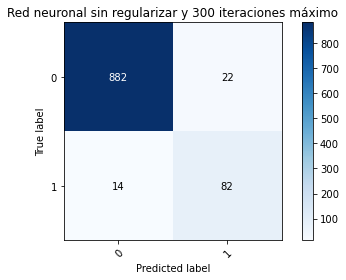

In [ ]:
plot_confusion_matrix(y_true = y_val, y_pred = predicted_val, normalize=False,title='Red neuronal sin regularizar y 300 iteraciones máximo',cmap=plt.cm.Blues)

### Regularización y control del sobreaprendizaje
Para dicha red vamos a variar el valor del parametro de aprendizaje $\lambda$ y el número máximo de iteraciones tratando de encontrar un modelo que no sobreaprenda y funcione mejor sobre el conjunto de validación para precisión y recall.

In [ ]:
def testLamdaItersNeuronas(X_train, y_train, X_val, y_val, rangoLambda, rangoIters, rangoNeuronas, input_size, num_labels, random_state = None):
    for hidden_size in rangoNeuronas:
        for lamda in rangoLambda:
            precision_lamda_train = []
            precision_lamda_val = []
            recall_lamda_train = []
            recall_lamda_val = []
            f1_lamda_train = []
            f1_lamda_val = []
            for max_iter in rangoIters:
                fmin = entrenaRed(X_train_norm, y_onehot(y_train, num_labels), input_size, (hidden_size,), num_labels, lamda, max_iter = max_iter, random_state = random_state)

                predicted_train = y_predicted(X_train_norm, input_size, (hidden_size,), num_labels, fmin.x)
                _, precision_train, recall_train, f1_train = metricas(predicted_train, y_train)
                precision_lamda_train.append(precision_train)
                recall_lamda_train.append(recall_train)
                f1_lamda_train.append(f1_train)

                predicted_val = y_predicted(X_val_norm, input_size, (hidden_size,), num_labels, fmin.x)
                _, precision_val, recall_val, f1_val = metricas(predicted_val, y_val)
                precision_lamda_val.append(precision_val)
                recall_lamda_val.append(recall_val)
                f1_lamda_val.append(f1_val)

            fig, (ax1,ax2) = plt.subplots(1,2)
            fig.set_size_inches(12,4)
            ax1.plot(rangoIters, precision_lamda_train, label = 'Train', color = 'blue')
            ax1.plot(rangoIters, precision_lamda_val, label = 'Validation', color = 'red')
            ax1.set_xlabel('Numero de iteraciones')
            ax1.set_ylabel('Precisión')
            ax1.set_title('Precisión para lambda = {}, neuronas = {}'.format(lamda, hidden_size))
            ax1.legend()

            ax2.plot(rangoIters, recall_lamda_train, label = 'Train', color = 'g')
            ax2.plot(rangoIters, recall_lamda_val, label = 'Validation', color = 'black')
            ax2.set_xlabel('Numero de iteraciones')
            ax2.set_ylabel('Recall')
            ax2.set_title('Recall para lambda = {}, neuronas = {}'.format(lamda, hidden_size))
            ax2.legend()
            fig.tight_layout()
            plt.show()

            fig, ax = plt.subplots()
            ax.plot(rangoIters, f1_lamda_train, label = 'Train', color = 'g')
            ax.plot(rangoIters, f1_lamda_val, label = 'Validation', color = 'black')
            plt.xlabel('Numero de iteraciones')
            plt.ylabel('F1')
            ax.set_title('F1 para lambda = {}, neuronas = {}'.format(lamda, hidden_size))
            plt.legend()
            plt.show()
            indice_maximo = f1_lamda_val.index(max(f1_lamda_val))
            print('Para el max_iter = {} tenemos máxima f1 en evaluación con lambda = {} y {} neuronas: {}'.format(rangoIters[indice_maximo], lamda, hidden_size, max(f1_lamda_val)))

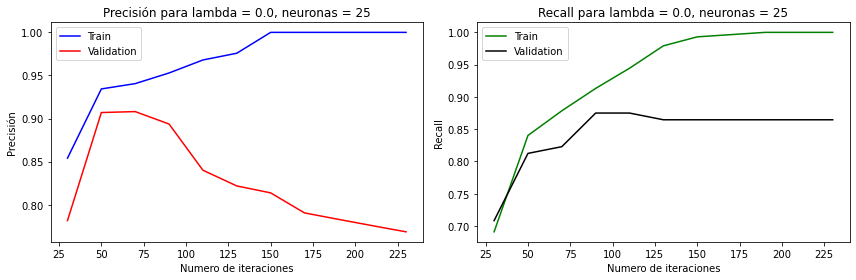

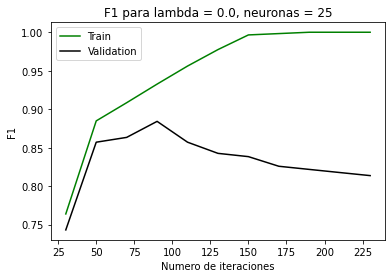

Para el max_iter = 90 tenemos máxima f1 en evaluación con lambda = 0.0 y 25 neuronas: 0.8842105263157894


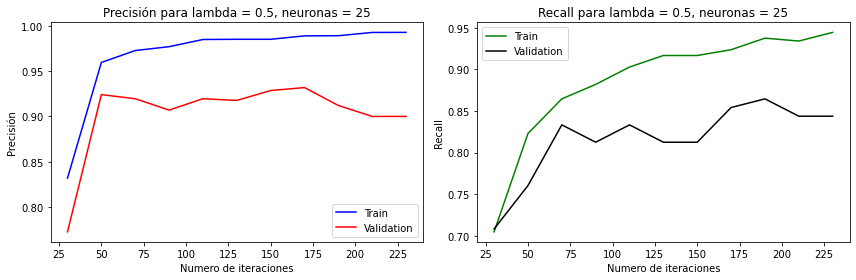

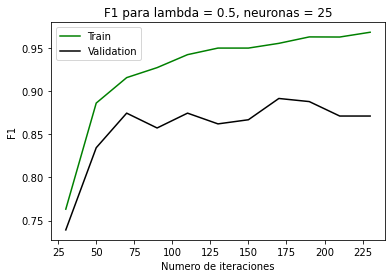

Para el max_iter = 170 tenemos máxima f1 en evaluación con lambda = 0.5 y 25 neuronas: 0.8913043478260869


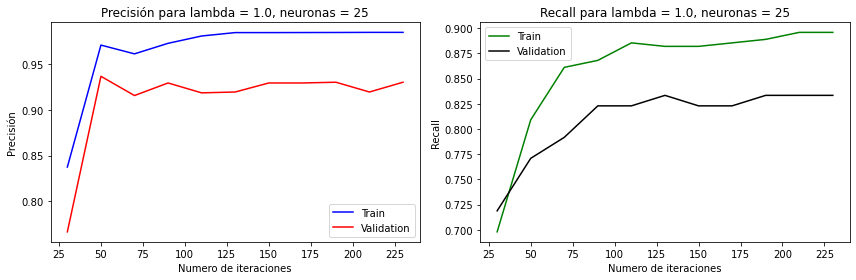

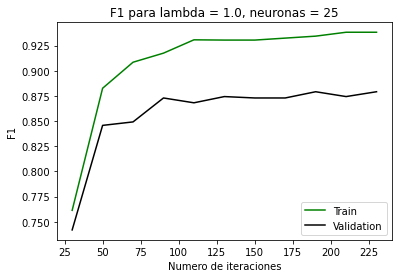

Para el max_iter = 190 tenemos máxima f1 en evaluación con lambda = 1.0 y 25 neuronas: 0.8791208791208791


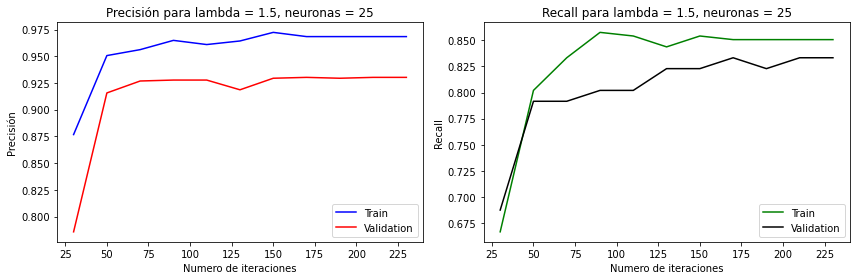

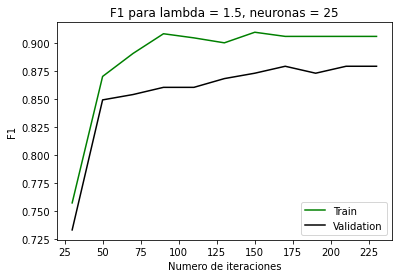

Para el max_iter = 170 tenemos máxima f1 en evaluación con lambda = 1.5 y 25 neuronas: 0.8791208791208791


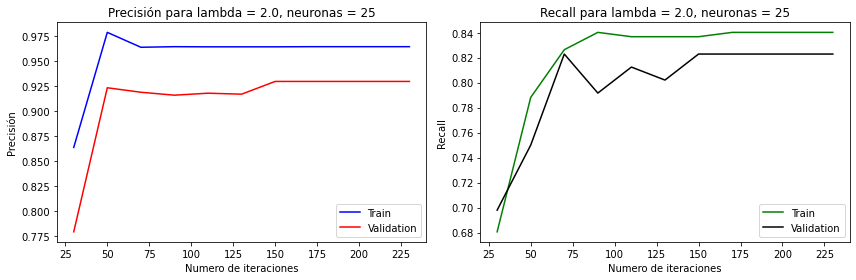

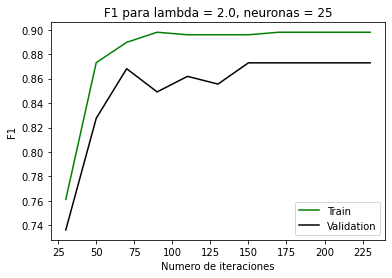

Para el max_iter = 150 tenemos máxima f1 en evaluación con lambda = 2.0 y 25 neuronas: 0.87292817679558


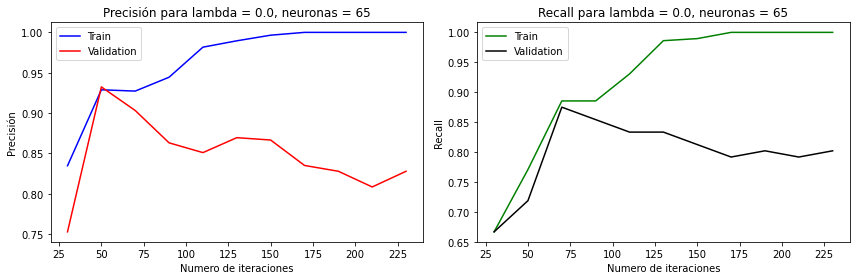

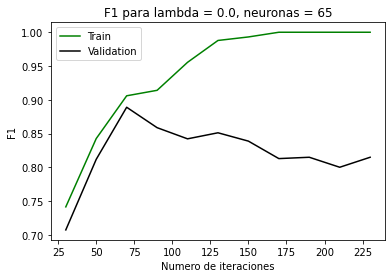

Para el max_iter = 70 tenemos máxima f1 en evaluación con lambda = 0.0 y 65 neuronas: 0.8888888888888888


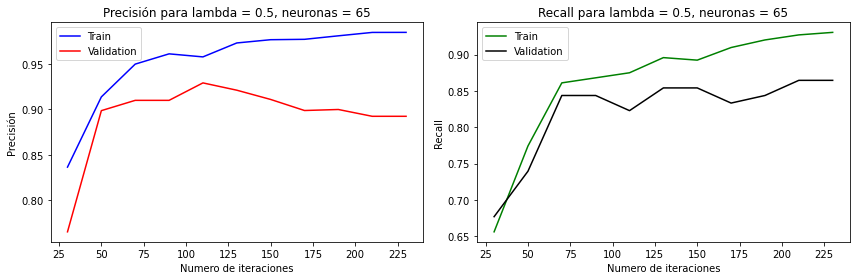

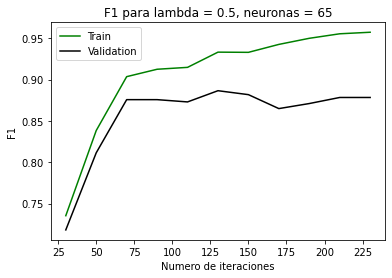

Para el max_iter = 130 tenemos máxima f1 en evaluación con lambda = 0.5 y 65 neuronas: 0.8864864864864865


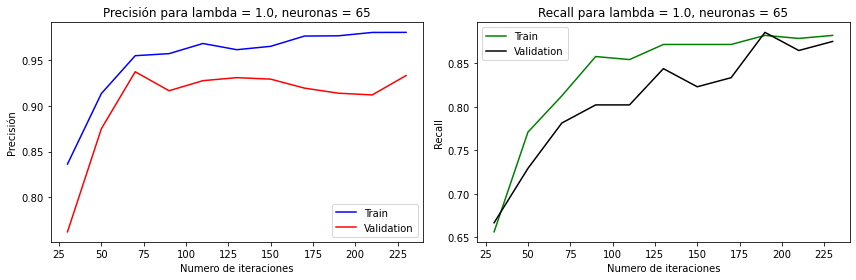

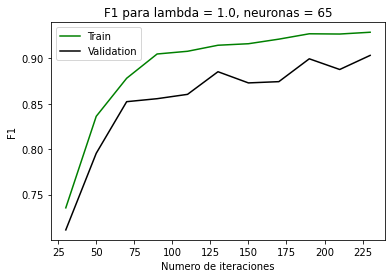

Para el max_iter = 230 tenemos máxima f1 en evaluación con lambda = 1.0 y 65 neuronas: 0.9032258064516129


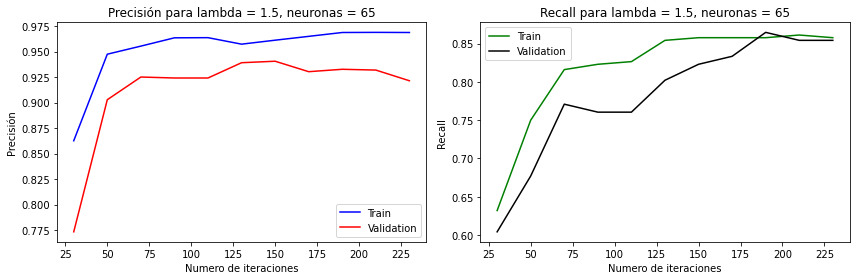

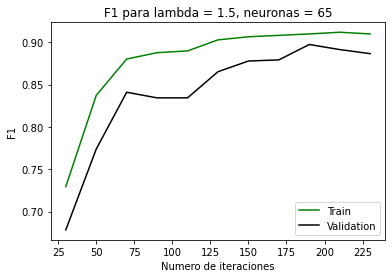

Para el max_iter = 190 tenemos máxima f1 en evaluación con lambda = 1.5 y 65 neuronas: 0.8972972972972973


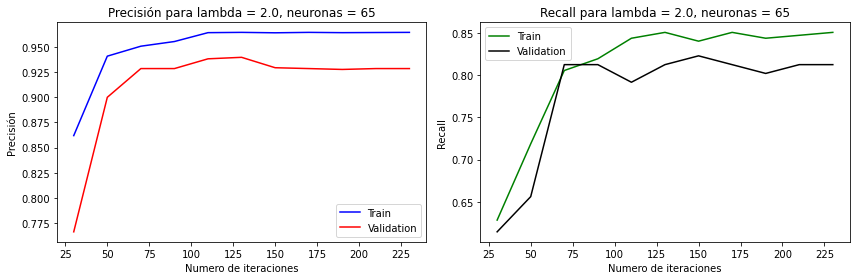

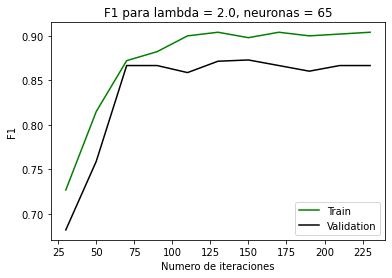

Para el max_iter = 150 tenemos máxima f1 en evaluación con lambda = 2.0 y 65 neuronas: 0.87292817679558


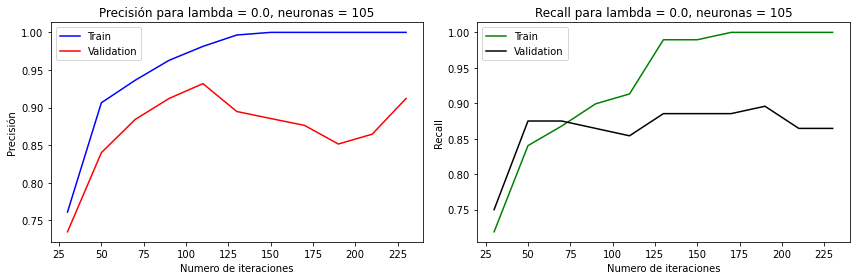

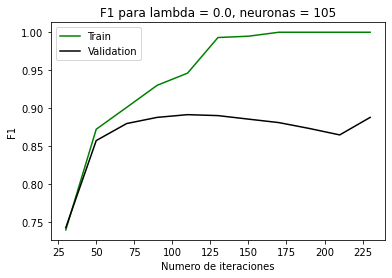

Para el max_iter = 110 tenemos máxima f1 en evaluación con lambda = 0.0 y 105 neuronas: 0.8913043478260869


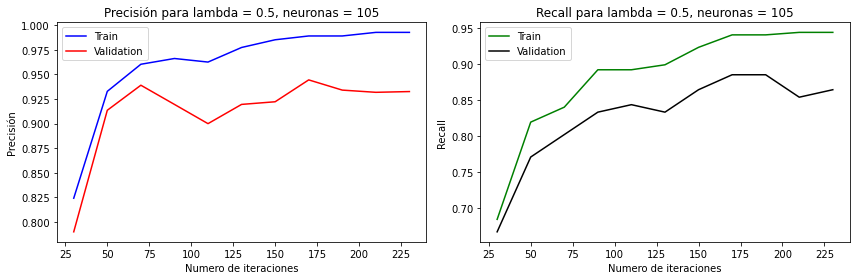

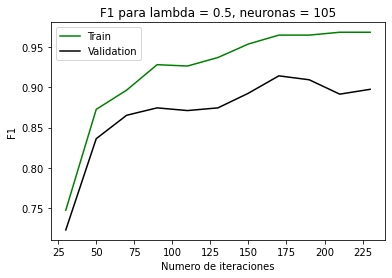

Para el max_iter = 170 tenemos máxima f1 en evaluación con lambda = 0.5 y 105 neuronas: 0.9139784946236558


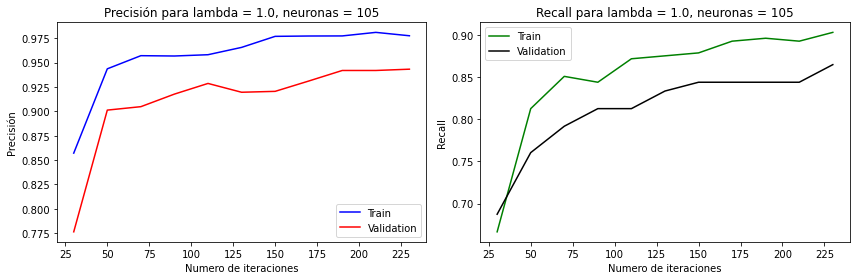

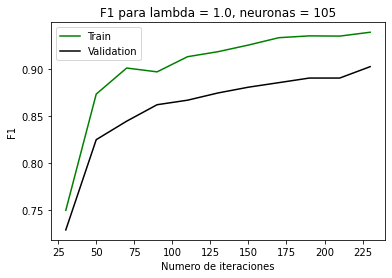

Para el max_iter = 230 tenemos máxima f1 en evaluación con lambda = 1.0 y 105 neuronas: 0.9021739130434783


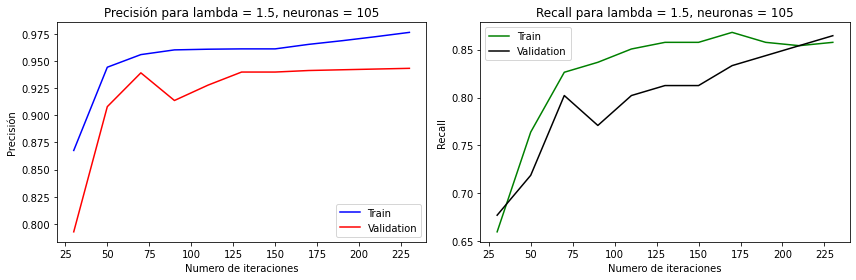

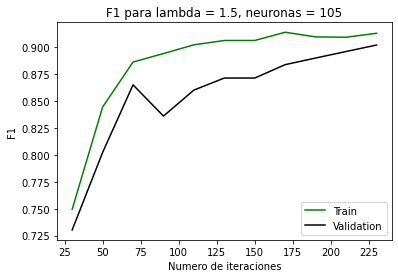

Para el max_iter = 230 tenemos máxima f1 en evaluación con lambda = 1.5 y 105 neuronas: 0.9021739130434783


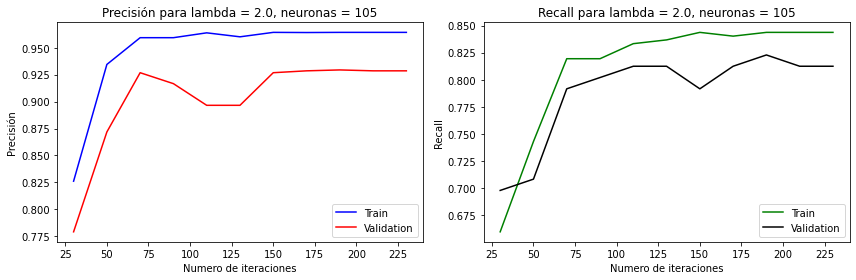

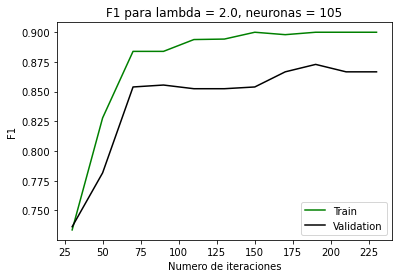

Para el max_iter = 190 tenemos máxima f1 en evaluación con lambda = 2.0 y 105 neuronas: 0.87292817679558


In [ ]:
# Para cada lambda en el primera rango representamos la precisión recall y f1 con las iteraciones del segundo rango
testLamdaItersNeuronas(X_train = X_train_norm, y_train = y_train, X_val = X_val, y_val = y_val, rangoLambda = np.arange(0,2.5,0.5), rangoIters = np.arange(30,250,20), rangoNeuronas = range(25,110,40), input_size = input_size, num_labels= num_labels, random_state = 100)

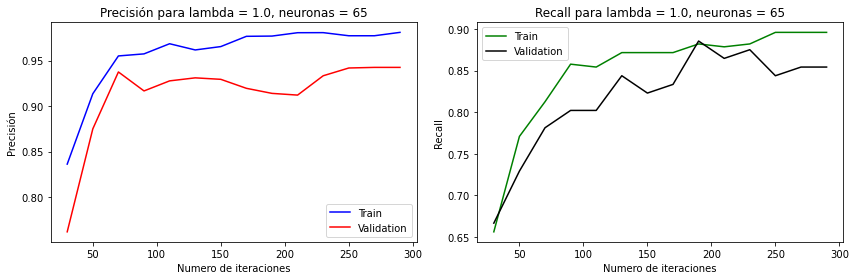

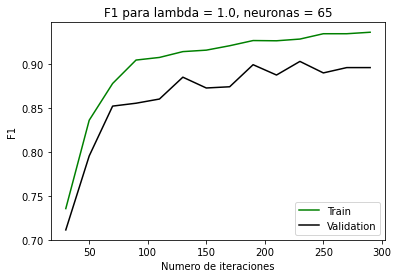

Para el max_iter = 230 tenemos máxima f1 en evaluación con lambda = 1.0 y 65 neuronas: 0.9032258064516129


In [ ]:
testLamdaItersNeuronas(X_train = X_train_norm, y_train = y_train, X_val = X_val_norm, y_val = y_val, rangoLambda = np.arange(1,1.1,0.5), rangoIters = np.arange(30,310,20), rangoNeuronas = range(65,66,40), input_size = input_size, num_labels= num_labels, random_state = 100)

### Test número de neuronas

### Red neuronal escogida (65 neuronas, $\lambda = 1$ y max_iter = 230) y prueba sobre conjunto de test

La red neuronal escogida tiene los siguientes resultados sobre el conjunto de entrenamiento y validación.

In [67]:
lamda = 1
max_iter = 230
hidden_size = (65,)
fmin = entrenaRed(X_train_norm, y_onehot(y_train, num_labels), input_size, hidden_size, num_labels, reg = lamda, max_iter = max_iter, random_state = 100)
predicted_train = y_predicted(X_train_norm, input_size, hidden_size, num_labels, fmin.x)
print('Resultados para train')
muestraMetricas(predicted_train, y_train)
predicted_val = y_predicted(X_val_norm, input_size, hidden_size, num_labels, fmin.x)
print('\nResultados para val')
muestraMetricas(predicted_val, y_val)

Resultados para train
Accuracy obtenido: 0.9863287762587529
Precisión obtenida: 0.9731800766283525
Recall obtenido: 0.8819444444444444
F1 obtenido: 0.9253187613843351

Resultados para val
Accuracy obtenido: 0.979
Precisión obtenida: 0.9213483146067416
Recall obtenido: 0.8541666666666666
F1 obtenido: 0.8864864864864865


Sobre el conjunto de test que no ha influido ni en su entrenamiento ni en la elección de los hiperparámetros obtiene resultados muy similares.

In [68]:
predicted_test = y_predicted(X_test_norm, input_size, hidden_size, num_labels, fmin.x)
print('\nResultados para test')
muestraMetricas(predicted_test, y_test)


Resultados para test
Accuracy obtenido: 0.982
Precisión obtenida: 0.975609756097561
Recall obtenido: 0.8333333333333334
F1 obtenido: 0.8988764044943819


Observamos en la matriz de confusión cierta tendencia a responder la clase minoritaria, menos de lo que debería.

Confusion matrix, without normalization
[[901   3]
 [ 16  80]]


<AxesSubplot:title={'center':'Red neuronal con lambda = 1 y 230 iteraciones máximo'}, xlabel='Predicted label', ylabel='True label'>

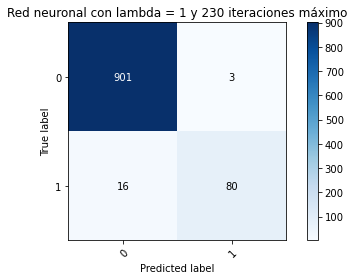

In [ ]:
plot_confusion_matrix(y_true = y_test, y_pred = predicted_test, normalize=False,title='Red neuronal con lambda = 1 y 230 iteraciones máximo',cmap=plt.cm.Blues)

### Pruebas de la red neuornal con varias capas
Modificamos algunas de las funciones que teniamos para trabajar con una capa para que puedan funcionar con una tupla que indique el número de neuoronas en cada capa oculta.

Prueba con más capas de 25 neuronas.

In [69]:
topologias = [(65,), (85,85), (65,65), (45,45), (85,85,85), (65,65,65), (45,45,45)]
input_size = X_train_norm.shape[1]
reg = 1
max_iter = 230
num_labels = 2
for topo in topologias:
    fmin = entrenaRed(X_train_norm, y_onehot(y_train, num_labels), input_size, topo, num_labels, reg, max_iter = max_iter, random_state = 100)
    print('Configuración {}'.format(topo))
    predicted_train = y_predicted(X_train_norm, input_size, topo, num_labels, fmin.x)
    print('Resultados para train lambda = {}, max_iter = {}'.format(reg, max_iter))
    muestraMetricas(predicted_train, y_train)
    predicted_val = y_predicted(X_val_norm, input_size, topo, num_labels, fmin.x)
    print('\nResultados para val lambda = {}, max_iter = {}'.format(reg, max_iter))
    muestraMetricas(predicted_val, y_val)
    print('\n\n')

Configuración (65,)
Resultados para train lambda = 1, max_iter = 230
Accuracy obtenido: 0.9863287762587529
Precisión obtenida: 0.9731800766283525
Recall obtenido: 0.8819444444444444
F1 obtenido: 0.9253187613843351

Resultados para val lambda = 1, max_iter = 230
Accuracy obtenido: 0.979
Precisión obtenida: 0.9213483146067416
Recall obtenido: 0.8541666666666666
F1 obtenido: 0.8864864864864865



Configuración (85, 85)
Resultados para train lambda = 1, max_iter = 230
Accuracy obtenido: 0.9913304434811604
Precisión obtenida: 0.9746376811594203
Recall obtenido: 0.9340277777777778
F1 obtenido: 0.9539007092198581

Resultados para val lambda = 1, max_iter = 230
Accuracy obtenido: 0.982
Precisión obtenida: 0.8979591836734694
Recall obtenido: 0.9166666666666666
F1 obtenido: 0.9072164948453607



Configuración (65, 65)
Resultados para train lambda = 1, max_iter = 230
Accuracy obtenido: 0.9913304434811604
Precisión obtenida: 0.9781021897810219
Recall obtenido: 0.9305555555555556
F1 obtenido: 0.953

### Suported vector machines

#### Kernel lineal
Primero, un modelo que sobreaprenda (parametro C = 100). Con un modelo lineal no consigue sobreaprender más.

In [33]:
svm = SVC(kernel = 'linear', C=100)
svm.fit(X_train_norm, y_train)

predicted_train = svm.predict(X_train_norm)
print('Resultados para train')
muestraMetricas(predicted_train, y_train)
predicted_val = svm.predict(X_val_norm)
print('\nResultados para eval')
muestraMetricas(predicted_val, y_val)

Resultados para train
Accuracy obtenido: 0.9549849949983328
Precisión obtenida: 0.8963730569948186
Recall obtenido: 0.6006944444444444
F1 obtenido: 0.7193347193347194

Resultados para eval
Accuracy obtenido: 0.947
Precisión obtenida: 0.8412698412698413
Recall obtenido: 0.5520833333333334
F1 obtenido: 0.6666666666666667


Confusion matrix, without normalization
[[894  10]
 [ 43  53]]


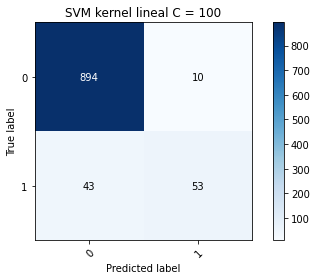

In [34]:
plot_confusion_matrix(y_true = y_val, y_pred = predicted_val, normalize=False,title='SVM kernel lineal C = 100',cmap=plt.cm.Blues)

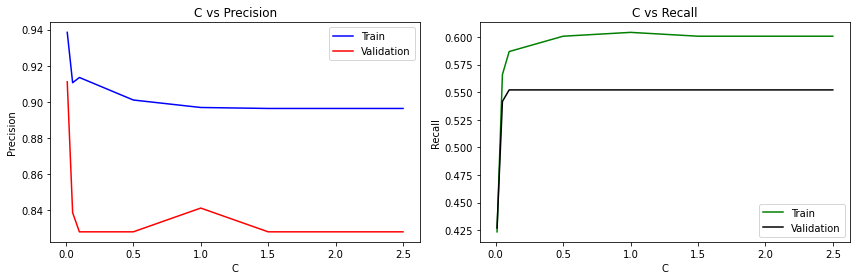

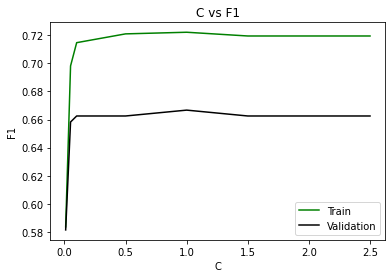

Para el valor de C 1 alcanzamos el f1 maximo en evaluacion: 0.6666666666666667


In [35]:
Cs = [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2.0, 2.5]
testParam(X_train_norm, y_train, X_val_norm, y_val, rango_parametro = Cs,
          nombre_modelo = 'SVM linear', nombre_parametro = 'C')

#### Kernel gaussiano
Modelo que sobreaprende

In [25]:
C= 100
sigma = 0.5
svm = SVC(kernel = 'rbf', C=C, gamma = 1/(2* sigma**2))
svm.fit(X_train_norm, y_train)

predicted_train = svm.predict(X_train_norm)
print('Resultados para train')
muestraMetricas(predicted_train, y_train)
predicted_val = svm.predict(X_val_norm)
print('\nResultados para eval')
muestraMetricas(predicted_val, y_val)

Resultados para train
Accuracy obtenido: 1.0
Precisión obtenida: 1.0
Recall obtenido: 1.0
F1 obtenido: 1.0

Resultados para eval
Accuracy obtenido: 0.907
Precisión obtenida: 0.7142857142857143
Recall obtenido: 0.052083333333333336
F1 obtenido: 0.0970873786407767


Apenas dice la clase minoritaria.

Confusion matrix, without normalization
[[902   2]
 [ 91   5]]


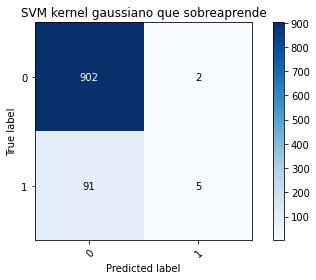

In [26]:
plot_confusion_matrix(y_true = y_val, y_pred = predicted_val, normalize=False,title='SVM kernel gaussiano que sobreaprende',cmap=plt.cm.Blues)

Con sigma = 4 y C= 24.5 se obtiene un 0.89 de f1 y el recall es alto. Parece que la curvas siguen creciendo. Representemos un poco más alla para este valor.

Sigma = 0.5


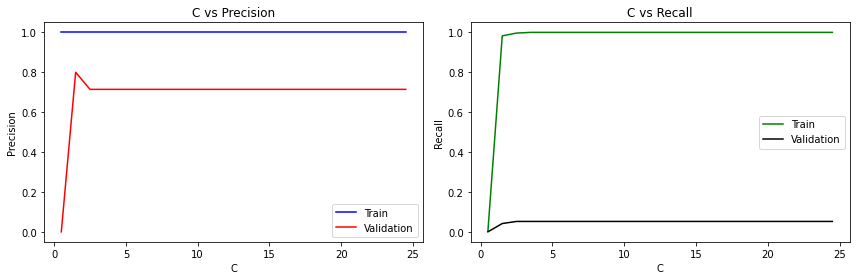

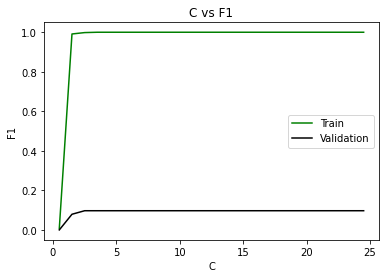

Para el valor de C 2.5 alcanzamos el f1 maximo en evaluacion: 0.0970873786407767

Sigma = 1.0


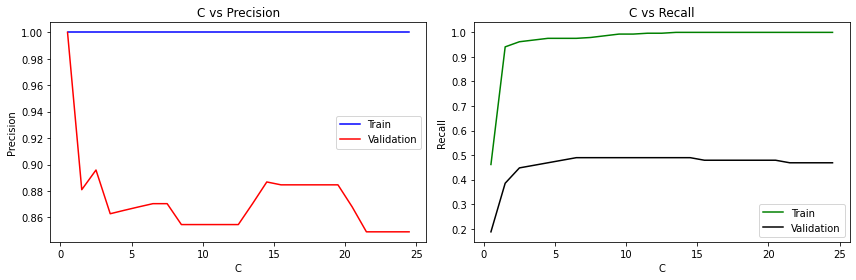

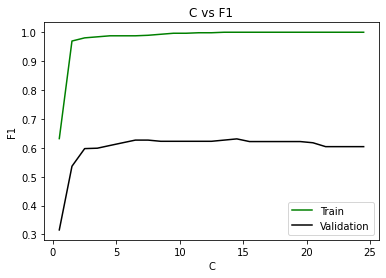

Para el valor de C 14.5 alcanzamos el f1 maximo en evaluacion: 0.6308724832214766

Sigma = 1.5


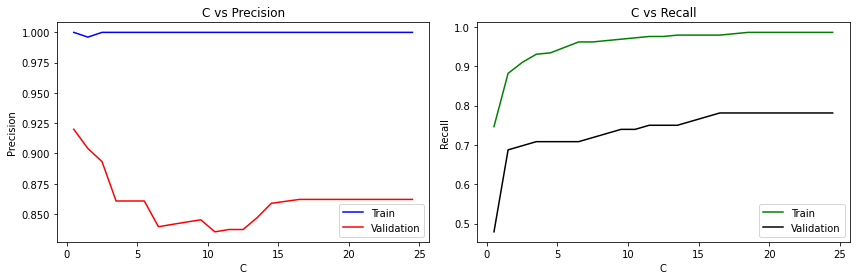

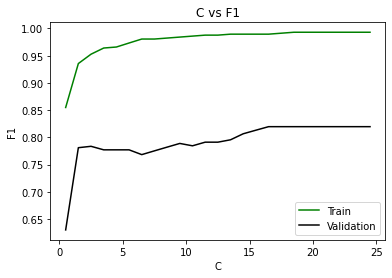

Para el valor de C 16.5 alcanzamos el f1 maximo en evaluacion: 0.8196721311475409

Sigma = 2.0


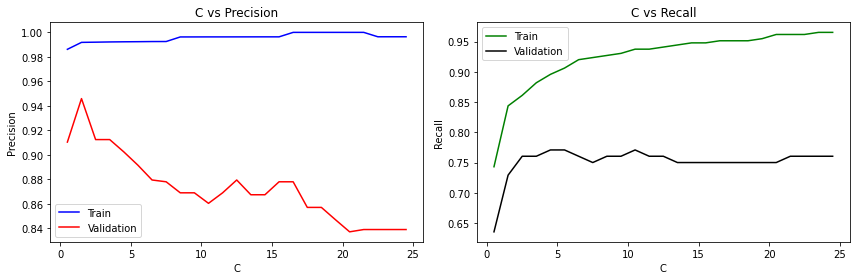

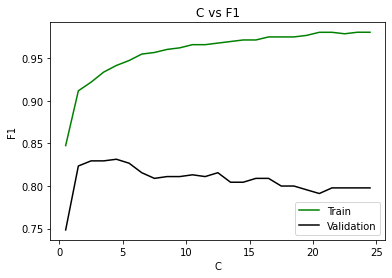

Para el valor de C 4.5 alcanzamos el f1 maximo en evaluacion: 0.8314606741573034

Sigma = 2.5


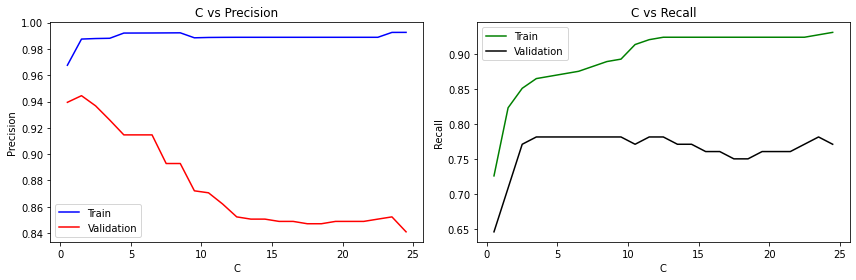

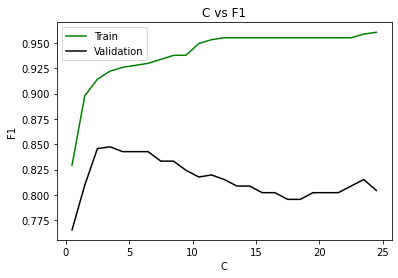

Para el valor de C 3.5 alcanzamos el f1 maximo en evaluacion: 0.847457627118644

Sigma = 3.0


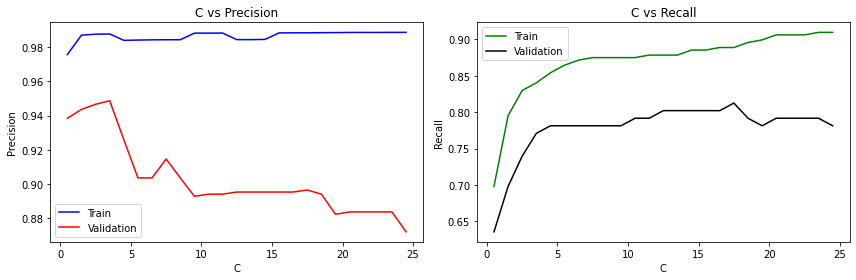

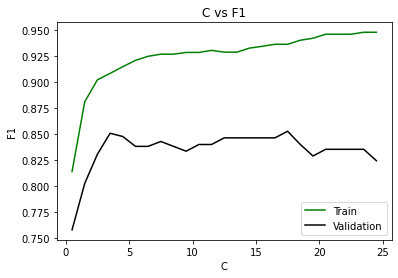

Para el valor de C 17.5 alcanzamos el f1 maximo en evaluacion: 0.8524590163934426

Sigma = 3.5


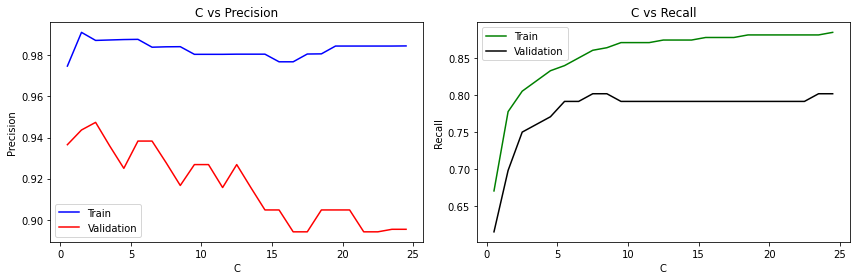

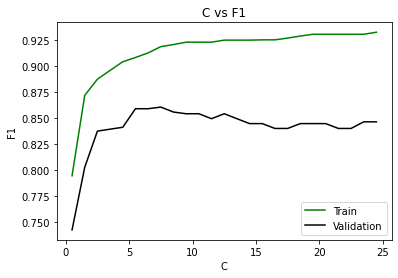

Para el valor de C 7.5 alcanzamos el f1 maximo en evaluacion: 0.8603351955307261

Sigma = 4.0


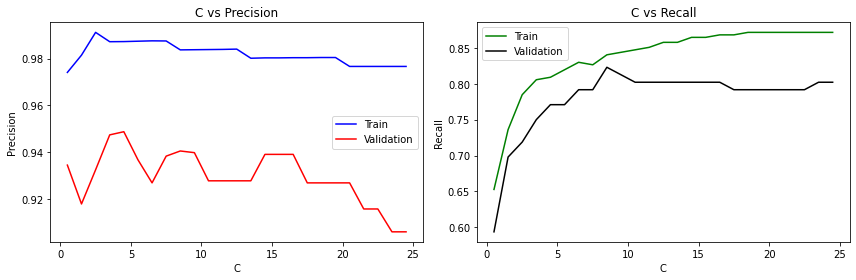

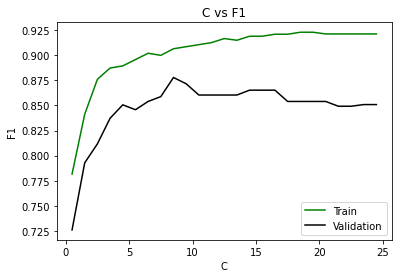

Para el valor de C 8.5 alcanzamos el f1 maximo en evaluacion: 0.8777777777777778

Sigma = 4.5


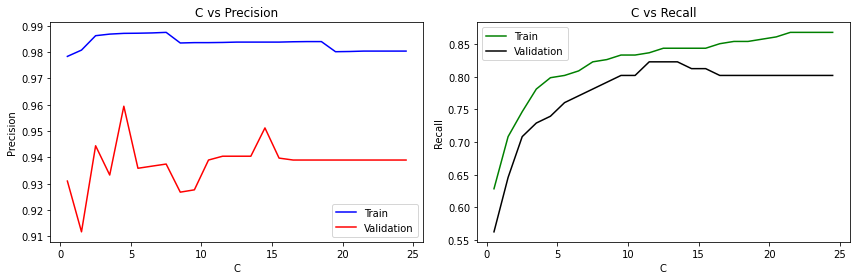

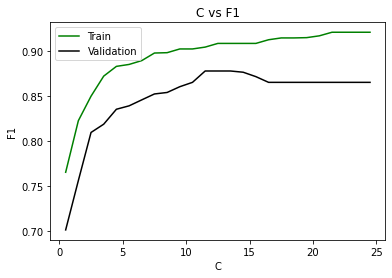

Para el valor de C 11.5 alcanzamos el f1 maximo en evaluacion: 0.8777777777777778

Sigma = 5.0


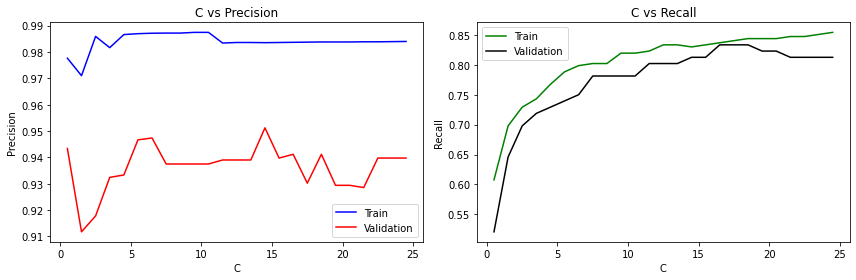

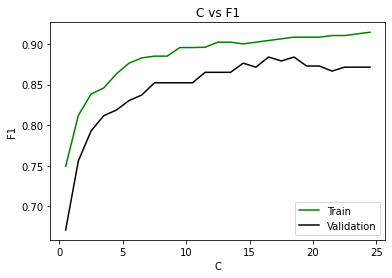

Para el valor de C 16.5 alcanzamos el f1 maximo en evaluacion: 0.8839779005524863

Sigma = 5.5


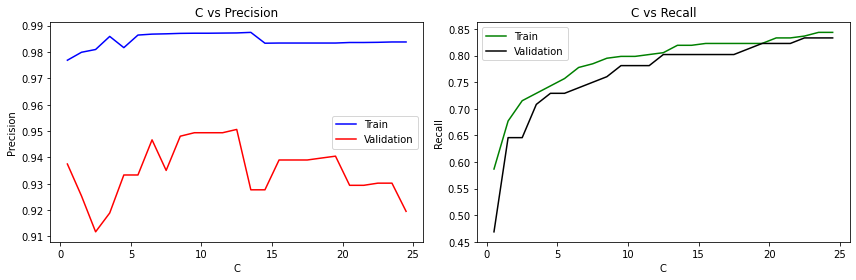

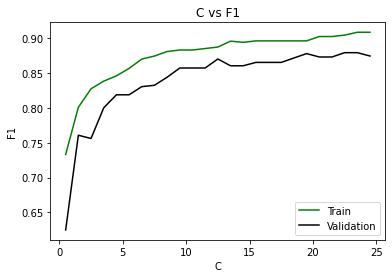

Para el valor de C 22.5 alcanzamos el f1 maximo en evaluacion: 0.8791208791208791

Sigma = 6.0


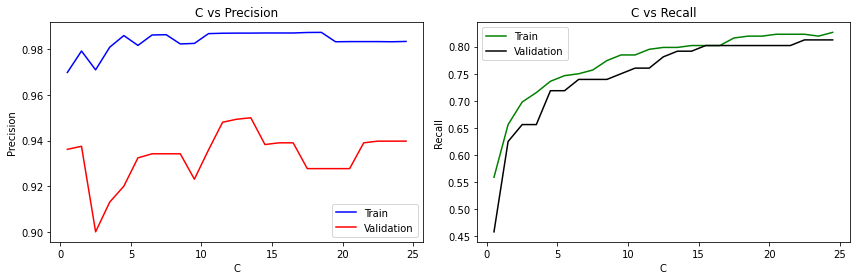

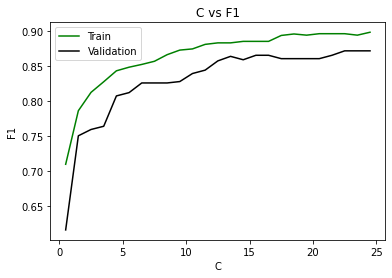

Para el valor de C 22.5 alcanzamos el f1 maximo en evaluacion: 0.8715083798882681

Sigma = 6.5


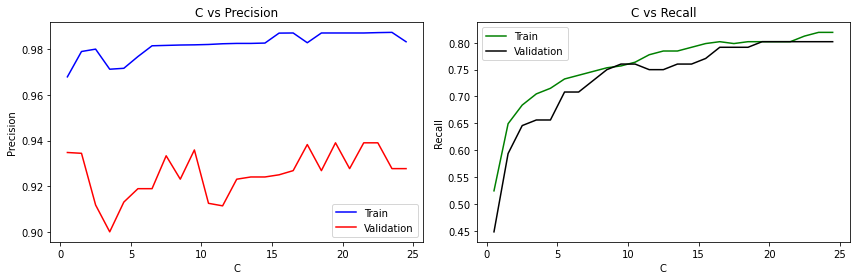

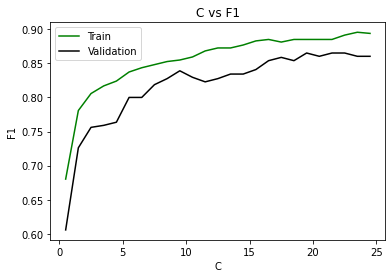

Para el valor de C 19.5 alcanzamos el f1 maximo en evaluacion: 0.8651685393258427

Sigma = 7.0


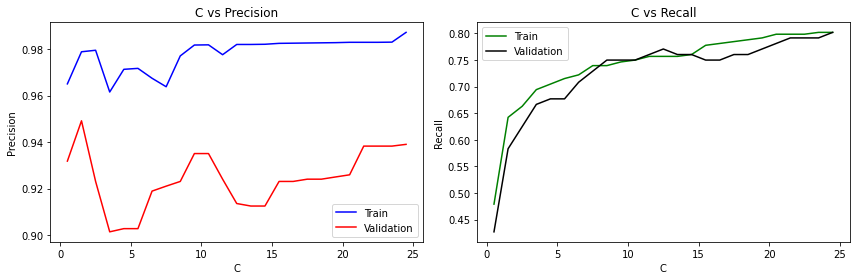

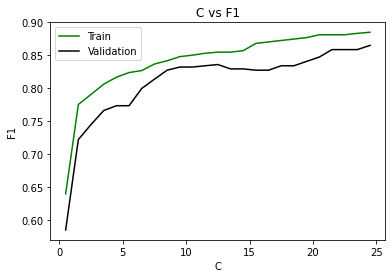

Para el valor de C 24.5 alcanzamos el f1 maximo en evaluacion: 0.8651685393258427

Sigma = 7.5


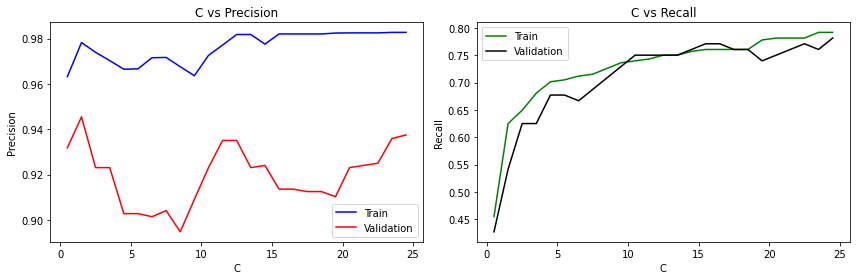

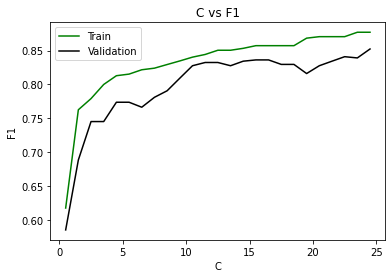

Para el valor de C 24.5 alcanzamos el f1 maximo en evaluacion: 0.8522727272727273

Sigma = 8.0


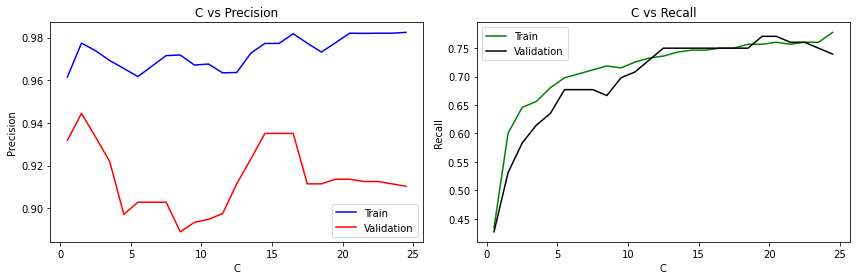

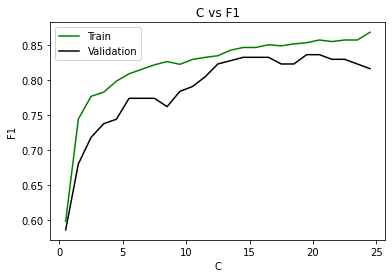

Para el valor de C 19.5 alcanzamos el f1 maximo en evaluacion: 0.8361581920903954

Sigma = 8.5


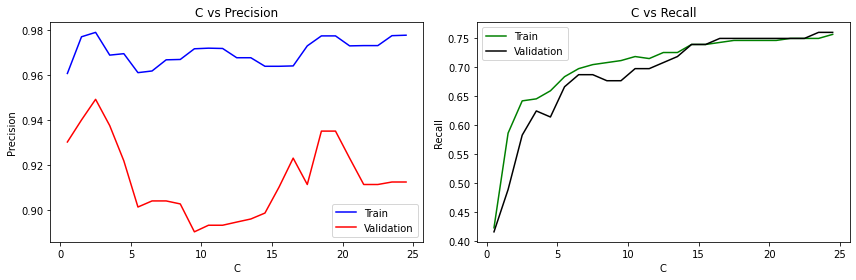

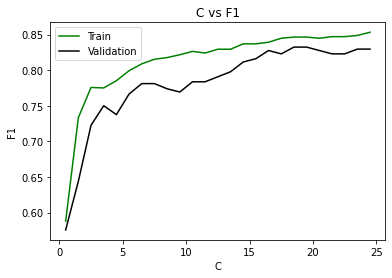

Para el valor de C 18.5 alcanzamos el f1 maximo en evaluacion: 0.8323699421965318

Sigma = 9.0


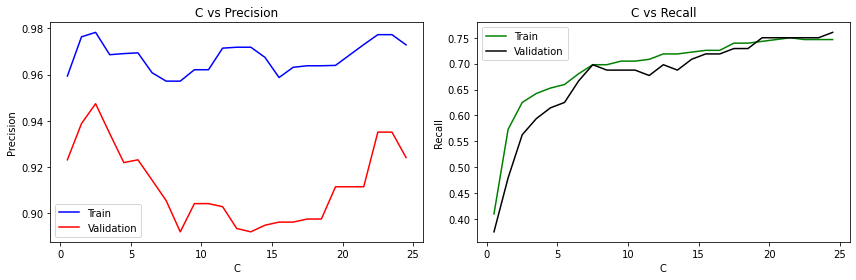

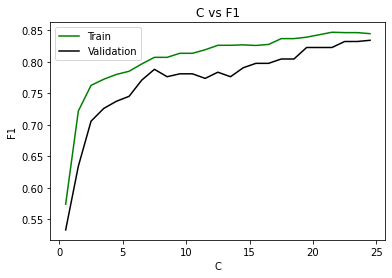

Para el valor de C 24.5 alcanzamos el f1 maximo en evaluacion: 0.8342857142857143

Sigma = 9.5


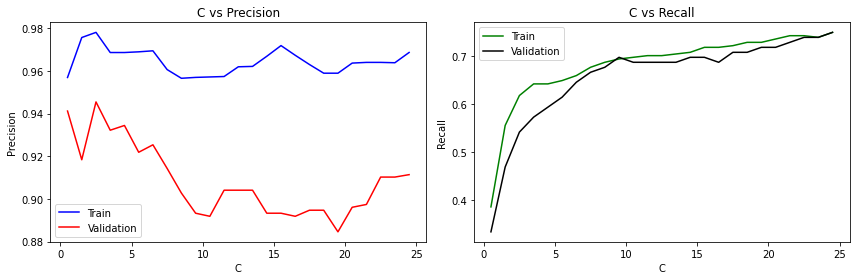

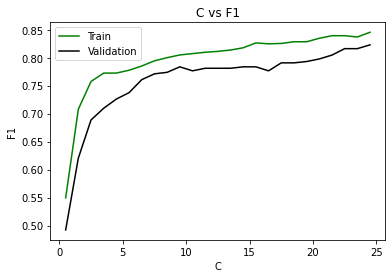

Para el valor de C 24.5 alcanzamos el f1 maximo en evaluacion: 0.8228571428571428

Sigma = 10.0


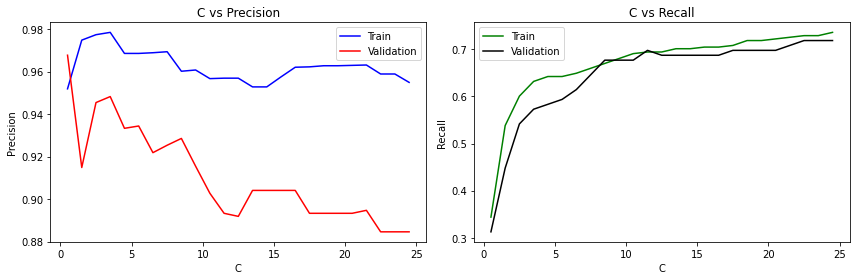

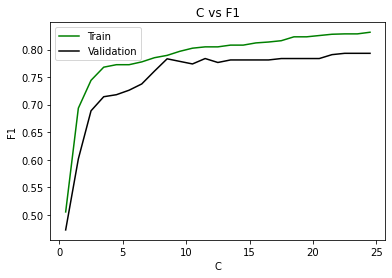

Para el valor de C 22.5 alcanzamos el f1 maximo en evaluacion: 0.7931034482758621



In [29]:
sigmas = np.arange(0.5,10.5,0.5)
Cs = np.arange(0.5,25,1)
for sigma in sigmas:
    print('Sigma = {}'.format(sigma))
    testParam(X_train_norm, y_train, X_val_norm, y_val, rango_parametro = Cs,
          nombre_modelo = 'SVM gaussian', nombre_parametro = 'C', random_state = 100, gamma = 1/(2* sigma**2))
    print()

Nos quedamos con sigma = 5 y C = 16.5, donde obtenemos resultados igual de buenos.

In [31]:
C= 16.5
sigma = 5
svm = SVC(kernel = 'rbf', C=C, gamma = 1/(2* sigma**2), random_state = 100)
svm.fit(X_train_norm, y_train)

predicted_train = svm.predict(X_train_norm)
print('Resultados para train')
muestraMetricas(predicted_train, y_train)
print()
predicted_val = svm.predict(X_val_norm)
print('Resultados para validación')
muestraMetricas(predicted_val, y_val)
print()
predicted_test = svm.predict(X_test_norm)
print('Resultados para test')
muestraMetricas(predicted_test, y_test)

Resultados para train
Accuracy obtenido: 0.9829943314438147
Precisión obtenida: 0.9836734693877551
Recall obtenido: 0.8368055555555556
F1 obtenido: 0.9043151969981239

Resultados para validación
Accuracy obtenido: 0.979
Precisión obtenida: 0.9411764705882353
Recall obtenido: 0.8333333333333334
F1 obtenido: 0.8839779005524863

Resultados para test
Accuracy obtenido: 0.979
Precisión obtenida: 0.9518072289156626
Recall obtenido: 0.8229166666666666
F1 obtenido: 0.88268156424581


### Árboles de decisión (EXTRA)

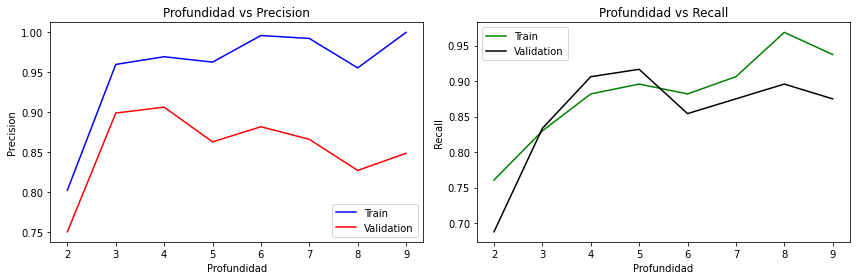

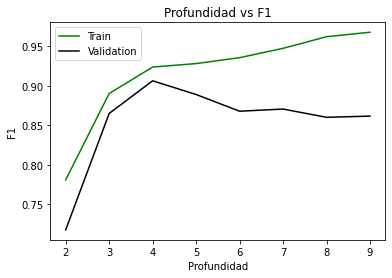

Para el valor de Profundidad 4 alcanzamos el f1 maximo en evaluacion: 0.90625


In [24]:
testParam(X_train_norm, y_train, X_val_norm, y_val, rango_parametro = np.arange(2, 10, 1), nombre_modelo = 'arbol decision', nombre_parametro = 'Profundidad')

Resultados para train
Accuracy obtenido: 0.9859953317772591
Precisión obtenida: 0.9694656488549618
Recall obtenido: 0.8819444444444444
F1 obtenido: 0.9236363636363636

Resultados para eval
Accuracy obtenido: 0.982
Precisión obtenida: 0.90625
Recall obtenido: 0.90625
F1 obtenido: 0.90625

Resultados para test
Accuracy obtenido: 0.985
Precisión obtenida: 0.9764705882352941
Recall obtenido: 0.8645833333333334
F1 obtenido: 0.9171270718232044

Matriz de confusion
Confusion matrix, without normalization
[[902   2]
 [ 13  83]]


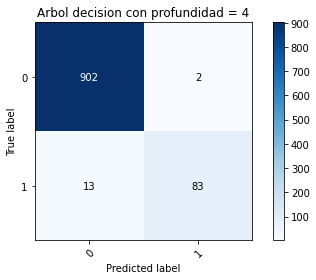

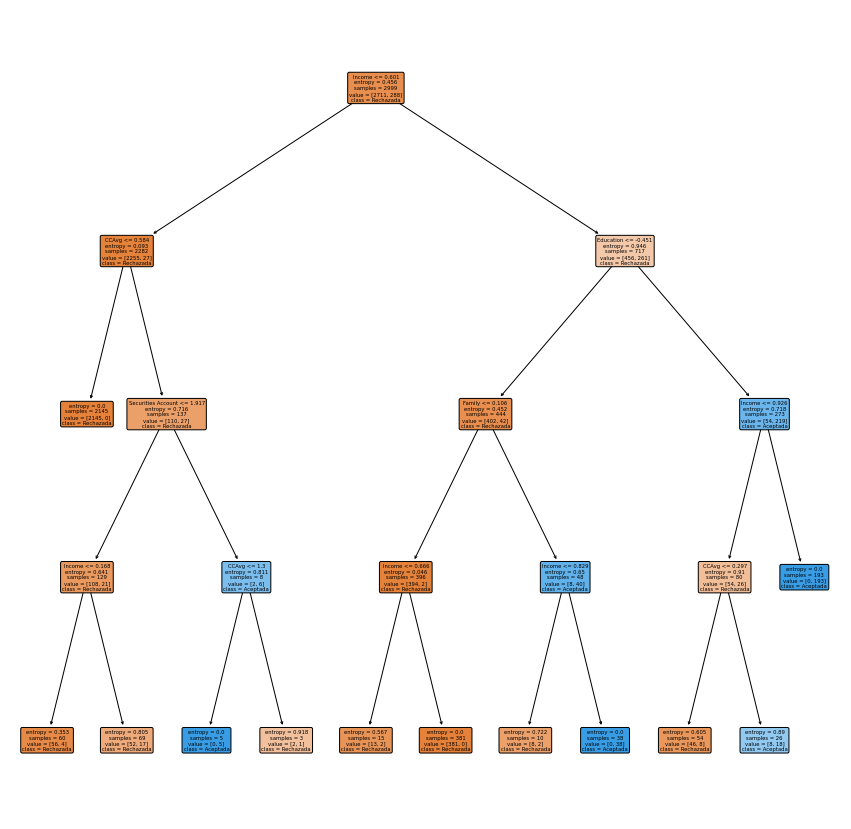

In [27]:
profundidad = 4
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = profundidad, min_samples_split = 2, random_state = 0)
tree = tree.fit(X_train_norm, y_train)

#Metricas con datos entrenamiento
predicted_train = tree.predict(X_train_norm)
print('Resultados para train')
muestraMetricas(predicted_train, y_train)

predicted_val = tree.predict(X_val_norm)
print('\nResultados para eval')
muestraMetricas(predicted_val, y_val)

predicted_test = tree.predict(X_test_norm)
print('\nResultados para test')
muestraMetricas(predicted_test, y_test)

print('\nMatriz de confusion')
plot_confusion_matrix(y_true = y_test, y_pred = predicted_test, normalize=False, title='Arbol decision con profundidad = {}'.format(profundidad), cmap=plt.cm.Blues)

plt.figure(figsize=(15,15))
plot_tree(tree, filled=True, feature_names = loan_rawdf.columns.values,
          class_names=['Rechazada', 'Aceptada'], rounded=True)
plt.show()

## Random forest (extra)


Número de árboles: 2


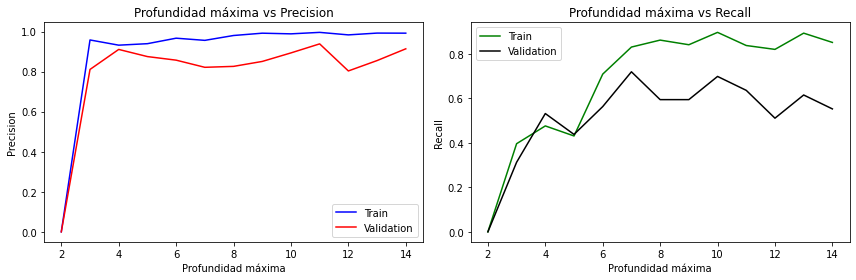

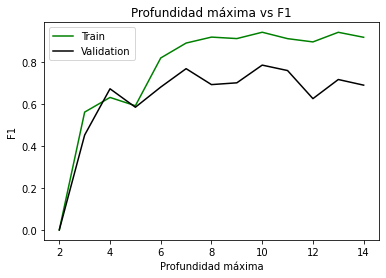

Para el valor de Profundidad máxima 10 alcanzamos el f1 maximo en evaluacion: 0.783625730994152

Número de árboles: 10


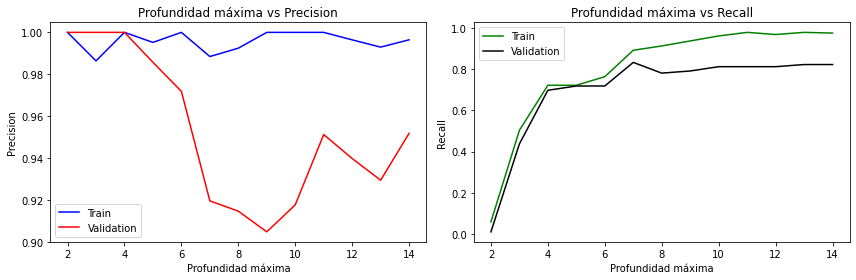

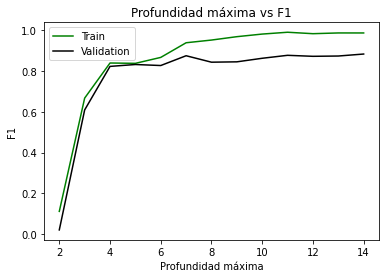

Para el valor de Profundidad máxima 14 alcanzamos el f1 maximo en evaluacion: 0.88268156424581

Número de árboles: 25


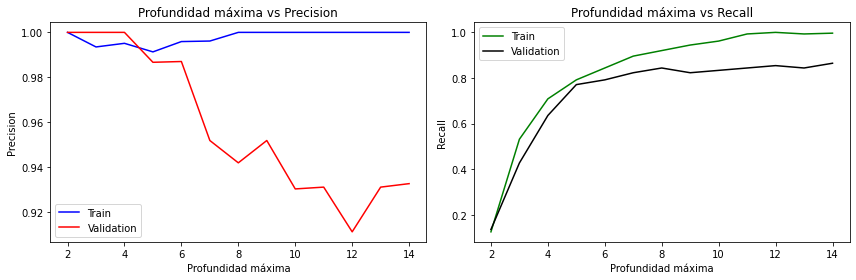

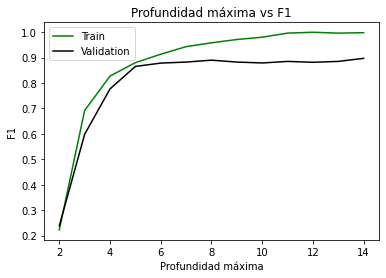

Para el valor de Profundidad máxima 14 alcanzamos el f1 maximo en evaluacion: 0.8972972972972973

Número de árboles: 50


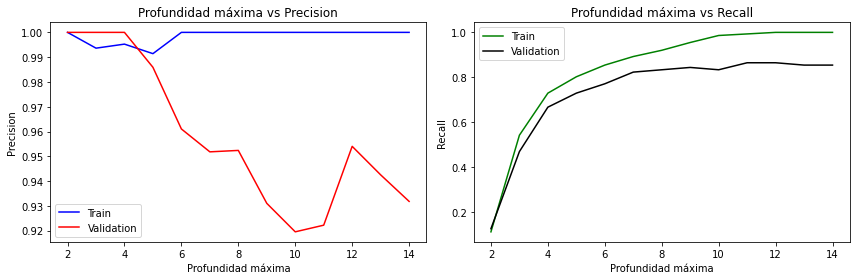

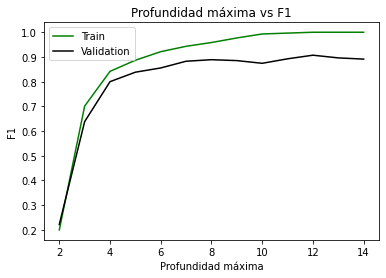

Para el valor de Profundidad máxima 12 alcanzamos el f1 maximo en evaluacion: 0.907103825136612

Número de árboles: 75


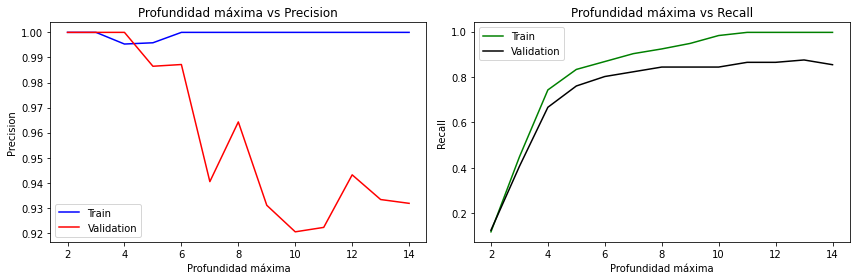

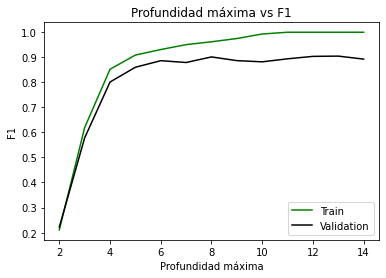

Para el valor de Profundidad máxima 13 alcanzamos el f1 maximo en evaluacion: 0.9032258064516129

Número de árboles: 100


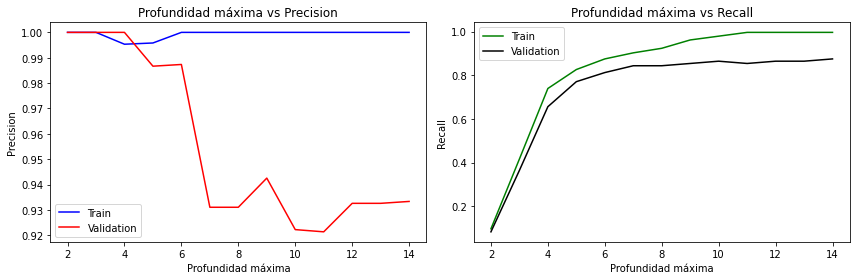

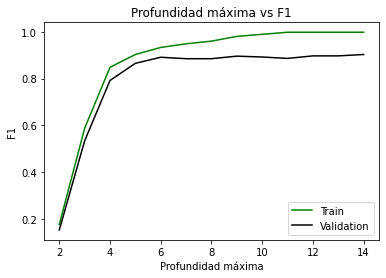

Para el valor de Profundidad máxima 14 alcanzamos el f1 maximo en evaluacion: 0.9032258064516129

Número de árboles: 500


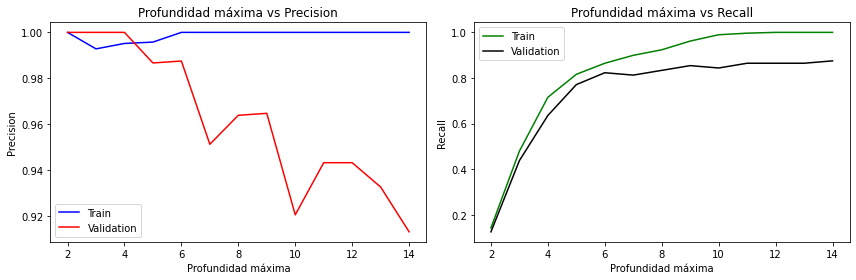

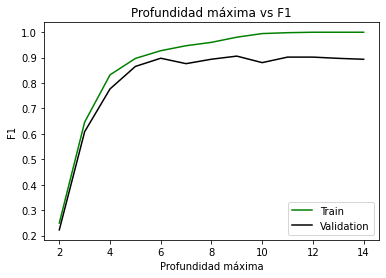

Para el valor de Profundidad máxima 9 alcanzamos el f1 maximo en evaluacion: 0.9060773480662984


In [50]:
n_estimators_range = [2,10,25,50,75,100,500]
for n_estimators in n_estimators_range:
  print('\nNúmero de árboles:', n_estimators)
  testParam(X_train_norm, y_train, X_val_norm, y_val, rango_parametro = np.arange(2, 15, 1), 
          nombre_modelo = 'random forest', nombre_parametro = 'Profundidad máxima', n_estimators = n_estimators)

Resultados para train
Accuracy obtenido: 1.0
Precisión obtenida: 1.0
Recall obtenido: 1.0
F1 obtenido: 1.0

Resultados para eval
Accuracy obtenido: 0.983
Precisión obtenida: 0.9540229885057471
Recall obtenido: 0.8645833333333334
F1 obtenido: 0.907103825136612

Resultados para test
Accuracy obtenido: 0.985
Precisión obtenida: 1.0
Recall obtenido: 0.84375
F1 obtenido: 0.9152542372881356

Matriz de confusion
Confusion matrix, without normalization
[[904   0]
 [ 15  81]]


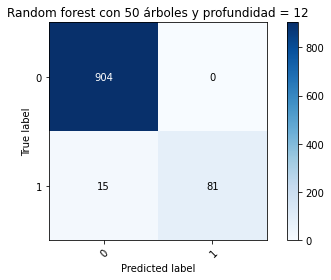

In [51]:
profundidad = 12
n_estimators = 50
modelo = RandomForestClassifier(n_estimators = n_estimators, max_depth = profundidad, random_state = 0)
modelo = modelo.fit(X_train_norm, y_train)

#Metricas con datos entrenamiento
predicted_train = modelo.predict(X_train_norm)
print('Resultados para train')
muestraMetricas(predicted_train, y_train)

predicted_val = modelo.predict(X_val_norm)
print('\nResultados para eval')
muestraMetricas(predicted_val, y_val)

predicted_test = modelo.predict(X_test_norm)
print('\nResultados para test')
muestraMetricas(predicted_test, y_test)

print('\nMatriz de confusion')
plot_confusion_matrix(y_true = y_test, y_pred = predicted_test, normalize=False, title='Random forest con {} árboles y profundidad = {}'.format(n_estimators, profundidad), cmap=plt.cm.Blues)

### Pruebas con Synthetic Minority Oversampling Technique (SMOT)
Conseguimos mejorar el recall

In [52]:
sm = SMOTE(random_state=333, sampling_strategy =  {0: 2712, 1:500})
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('Número de ejemplos de entrenamiento: ', len(y_train_res))
print('Porcentaje de la clase 0 en entrenamiento: ', np.sum(y_train_res == 0) / len(y_train_res)*100, '%') 
print('Porcentaje de la clase 1 en entrenamiento: ', np.sum(y_train_res == 1) / len(y_train_res)*100, '%') 

Número de ejemplos de entrenamiento:  3212
Porcentaje de la clase 0 en entrenamiento:  84.43337484433376 %
Porcentaje de la clase 1 en entrenamiento:  15.566625155666253 %


/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (2712) in class 0 will be larger than the number of samples in the majority class (class #0 -> 2711)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [53]:
X_train_norm_res, _ ,_ = normalize_data(X_train_res)
X_val_norm, _ ,_ = normalize_data(X_val)
X_test_norm, _ ,_ = normalize_data(X_test)

[3.76184578e+01 7.82245479e+01 9.31410480e+04 2.38811974e+00
 2.04621848e+00 1.90392792e+00 5.87503740e+01 1.04144825e-01
 7.07356627e-02 5.92408676e-01 2.96007023e-01]
[1.16972883e+01 4.80862083e+01 1.79085411e+03 1.13037296e+00
 1.80293779e+00 8.30361683e-01 1.05551984e+02 3.01746183e-01
 2.47526238e-01 4.85691869e-01 4.51324668e-01]
[3.7183000e+01 7.2417000e+01 9.3185745e+04 2.4590000e+00 1.9110200e+00
 1.8950000e+00 5.8364000e+01 1.1300000e-01 6.2000000e-02 6.1600000e-01
 2.8800000e-01]
[1.18957770e+01 4.54807114e+01 1.71901001e+03 1.15426124e+00
 1.73013224e+00 8.41412503e-01 1.05281288e+02 3.16592798e-01
 2.41155551e-01 4.86357893e-01 4.52831094e-01]
[3.7825000e+01 7.5252000e+01 9.3242055e+04 2.3840000e+00 1.9848200e+00
 1.8760000e+00 5.7787000e+01 9.8000000e-02 7.0000000e-02 5.8500000e-01
 2.9800000e-01]
[1.19566038e+01 4.61891816e+01 1.71864362e+03 1.14566313e+00
 1.77193628e+00 8.47716934e-01 1.02734374e+02 2.97314648e-01
 2.55147016e-01 4.92722031e-01 4.57379492e-01]


#### Regresión logística SMOT

In [54]:
poly = PolynomialFeatures(3)
X_train_norm_poly = poly.fit_transform(X_train_norm_res)
X_val_norm_poly = poly.fit_transform(X_val_norm)
X_test_norm_poly = poly.fit_transform(X_test_norm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in matmul
  import sys


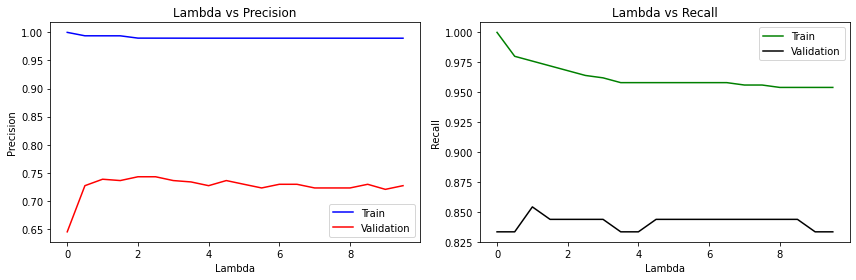

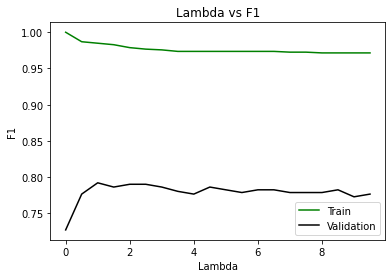

Para el valor de Lambda 1.0 alcanzamos el f1 maximo en evaluacion: 0.7922705314009663


In [55]:
testParam(X_train_norm_poly, y_train_res, X_val_norm_poly, y_val, rango_parametro = np.arange(0, 10, 0.5),
          nombre_modelo = 'regresion logistica', nombre_parametro = 'Lambda')

Resultados para train
Accuracy obtenido: 0.9912826899128269
Precisión obtenida: 0.9896265560165975
Recall obtenido: 0.954
F1 obtenido: 0.9714867617107943

Resultados para eval
Accuracy obtenido: 0.954
Precisión obtenida: 0.7272727272727273
Recall obtenido: 0.8333333333333334
F1 obtenido: 0.7766990291262137

Resultados para test
Accuracy obtenido: 0.974
Precisión obtenida: 0.8431372549019608
Recall obtenido: 0.8958333333333334
F1 obtenido: 0.8686868686868686

Matriz de confusion
Confusion matrix, without normalization
[[888  16]
 [ 10  86]]


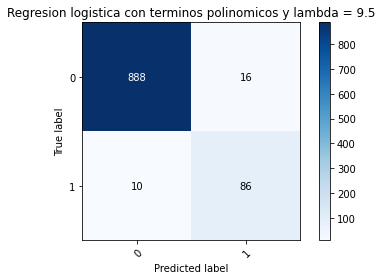

In [63]:
lamda = 9.5
theta = np.zeros(X_train_norm_poly.shape[1])
result = opt.fmin_tnc(func = costeRegu, x0 = theta, fprime = gradienteRegu, args=(X_train_norm_poly, y_train_res, lamda))
theta_opt = result[0]

#Metricas con datos entrenamiento
predicted_train = sigmoide(np.matmul(X_train_norm_poly, theta_opt)) >= 0.5
print('Resultados para train')
muestraMetricas(predicted_train, y_train_res)

predicted_val = sigmoide(np.matmul(X_val_norm_poly, theta_opt)) >= 0.5
print('\nResultados para eval')
muestraMetricas(predicted_val, y_val)

predicted_test = sigmoide(np.matmul(X_test_norm_poly, theta_opt)) >= 0.5
print('\nResultados para test')
muestraMetricas(predicted_test, y_test)

print('\nMatriz de confusion')
plot_confusion_matrix(y_true = y_test, y_pred = predicted_test, normalize=False, title='Regresion logistica con terminos polinomicos y lambda = {}'.format(lamda), cmap=plt.cm.Blues)

#### Red neuronal SMOT

In [65]:
input_size = X_train_norm.shape[1]
lamda = 1
max_iter = 230
num_labels = 2
hidden_size = (65,)
fmin = entrenaRed(X_train_norm_res, y_onehot(y_train_res, num_labels), input_size, hidden_size, num_labels, reg = lamda, max_iter = max_iter, random_state = 100)
predicted_train = y_predicted(X_train_norm_res, input_size, hidden_size, num_labels, fmin.x)
print('Resultados para train')
muestraMetricas(predicted_train, y_train_res)
predicted_val = y_predicted(X_val_norm, input_size, hidden_size, num_labels, fmin.x)
print('\nResultados para eval')
muestraMetricas(predicted_val, y_val)
predicted_test = y_predicted(X_test_norm, input_size, hidden_size, num_labels, fmin.x)
print('\nResultados para test')
muestraMetricas(predicted_test, y_test)

Resultados para train
Accuracy obtenido: 0.9887920298879203
Precisión obtenida: 0.9853556485355649
Recall obtenido: 0.942
F1 obtenido: 0.9631901840490797

Resultados para eval
Accuracy obtenido: 0.976
Precisión obtenida: 0.8333333333333334
Recall obtenido: 0.9375
F1 obtenido: 0.8823529411764706

Resultados para test
Accuracy obtenido: 0.984
Precisión obtenida: 0.9
Recall obtenido: 0.9375
F1 obtenido: 0.9183673469387755


#### SVM SMOT

In [66]:
C= 16.5
sigma = 5
svm = SVC(kernel = 'rbf', C=C, gamma = 1/(2* sigma**2), random_state = 100)
svm.fit(X_train_norm_res, y_train_res)

predicted_train = svm.predict(X_train_norm_res)
print('Resultados para train')
muestraMetricas(predicted_train, y_train_res)

predicted_val = svm.predict(X_val_norm)
print('Resultados para validación')
muestraMetricas(predicted_val, y_val)

predicted_test = svm.predict(X_test_norm)
print('Resultados para test')
muestraMetricas(predicted_test, y_test)

Resultados para train
Accuracy obtenido: 0.9831880448318805
Precisión obtenida: 0.9744680851063829
Recall obtenido: 0.916
F1 obtenido: 0.9443298969072164
Resultados para validación
Accuracy obtenido: 0.963
Precisión obtenida: 0.7706422018348624
Recall obtenido: 0.875
F1 obtenido: 0.8195121951219513
Resultados para test
Accuracy obtenido: 0.98
Precisión obtenida: 0.8958333333333334
Recall obtenido: 0.8958333333333334
F1 obtenido: 0.8958333333333334


#### Árbol de decision SMOT

Resultados para train
Accuracy obtenido: 0.9838107098381071
Precisión obtenida: 0.9848484848484849
Recall obtenido: 0.91
F1 obtenido: 0.9459459459459459

Resultados para eval
Accuracy obtenido: 0.861
Precisión obtenida: 0.40611353711790393
Recall obtenido: 0.96875
F1 obtenido: 0.5723076923076924

Resultados para test
Accuracy obtenido: 0.851
Precisión obtenida: 0.3872340425531915
Recall obtenido: 0.9479166666666666
F1 obtenido: 0.5498489425981874

Matriz de confusion
Confusion matrix, without normalization
[[760 144]
 [  5  91]]


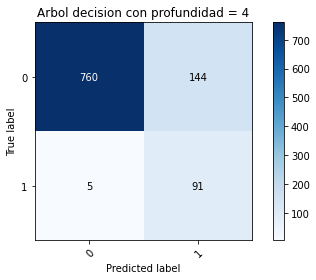

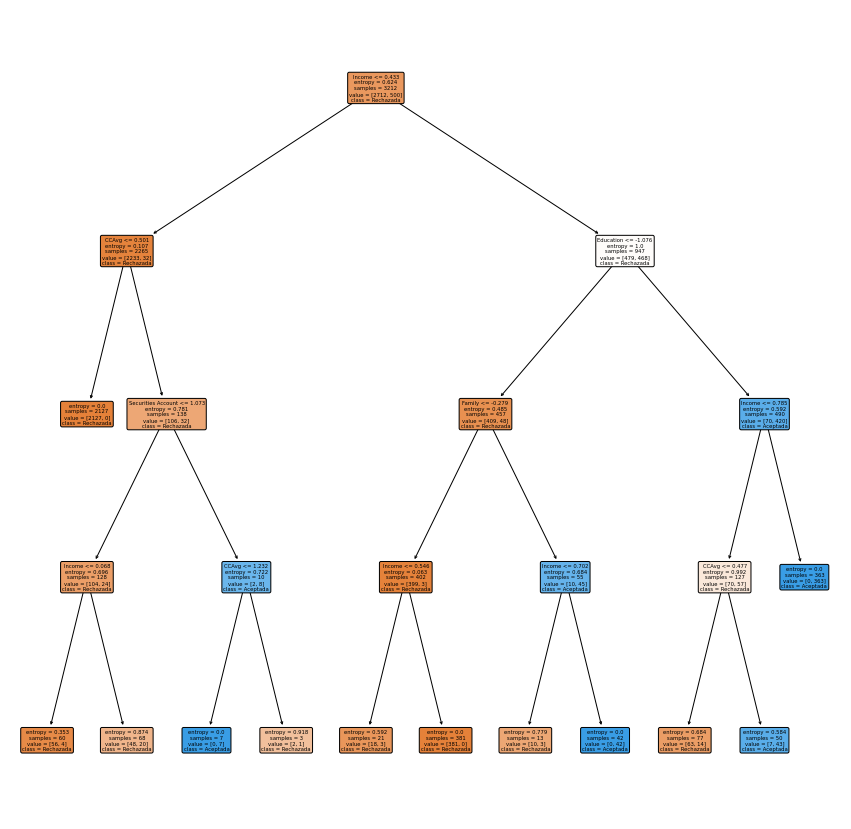

In [61]:
profundidad = 4
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = profundidad, min_samples_split = 2, random_state = 0)
tree = tree.fit(X_train_norm_res, y_train_res)

#Metricas con datos entrenamiento
predicted_train = tree.predict(X_train_norm_res)
print('Resultados para train')
muestraMetricas(predicted_train, y_train_res)

predicted_val = tree.predict(X_val_norm)
print('\nResultados para eval')
muestraMetricas(predicted_val, y_val)

predicted_test = tree.predict(X_test_norm)
print('\nResultados para test')
muestraMetricas(predicted_test, y_test)

print('\nMatriz de confusion')
plot_confusion_matrix(y_true = y_test, y_pred = predicted_test, normalize=False, title='Arbol decision con profundidad = 4', cmap=plt.cm.Blues)


Resultados para train
Accuracy obtenido: 1.0
Precisión obtenida: 1.0
Recall obtenido: 1.0
F1 obtenido: 1.0

Resultados para eval
Accuracy obtenido: 0.967
Precisión obtenida: 0.7603305785123967
Recall obtenido: 0.9583333333333334
F1 obtenido: 0.8479262672811061

Resultados para test
Accuracy obtenido: 0.876
Precisión obtenida: 0.4326923076923077
Recall obtenido: 0.9375
F1 obtenido: 0.5921052631578948

Matriz de confusion
Confusion matrix, without normalization
[[786 118]
 [  6  90]]


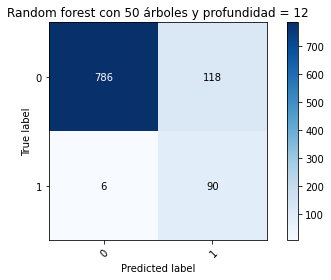

In [62]:
profundidad = 12
n_estimators = 50
modelo = RandomForestClassifier(n_estimators = n_estimators, max_depth = profundidad, random_state = 0)
modelo = modelo.fit(X_train_norm_res, y_train_res)

#Metricas con datos entrenamiento
predicted_train = modelo.predict(X_train_norm_res)
print('Resultados para train')
muestraMetricas(predicted_train, y_train_res)

predicted_val = modelo.predict(X_val_norm)
print('\nResultados para eval')
muestraMetricas(predicted_val, y_val)

predicted_test = modelo.predict(X_test_norm)
print('\nResultados para test')
muestraMetricas(predicted_test, y_test)

print('\nMatriz de confusion')
plot_confusion_matrix(y_true = y_test, y_pred = predicted_test, normalize=False, title='Random forest con {} árboles y profundidad = {}'.format(n_estimators, profundidad), cmap=plt.cm.Blues)